In this notebook, we will explore our preprocessed dataset.  We will analyze the data for outliers, correlated features, and merits in features against the selected features the model outputs.  We will use different feature selection methods such as PCA, Forward/Backward selection, and Decision Trees; and will determine which features we can exclude based on the results and error rate.  We want to train our models only on the features most important to determining the popularity of the song per genre (with the exception of Decision Tree since it performs its own feature selection).

We use kMeans to explore how well kMeans could predict a song's popularity based on its features and perhaps even if it can cluster songs into genres based on the track's features.

This data has been preprocessed and does not contain null values.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.tree import export_graphviz
from IPython.display import Image

from sklearn import tree
from sklearn import naive_bayes
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA as PCA
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN

from sklearn import metrics
from sklearn import feature_selection
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix


## Analyze data for outliers

In [2]:
raw_data = pd.read_csv('./data/rawData_final.csv')

In [3]:
print(raw_data.shape)
raw_data.describe(include='all').T

(23127, 34)


count unique  top  freq        mean        std       min  \
year              23127    NaN  NaN   NaN     2011.24    5.42064      2002   
genre             23127      5  r&b  5233         NaN        NaN       NaN   
popular           23127    NaN  NaN   NaN    0.244476   0.429785         0   
chartrank         23127    NaN  NaN   NaN     10.1429     22.372         0   
acousticness      23127    NaN  NaN   NaN    0.292056   0.283272  2.05e-06   
danceability      23127    NaN  NaN   NaN    0.622599   0.143972    0.0917   
energy            23127    NaN  NaN   NaN    0.623486   0.206216   0.00154   
duration_ms       23127    NaN  NaN   NaN    0.130604  0.0432525         0   
instrumentalness  23127    NaN  NaN   NaN   0.0895416   0.242499         0   
valence           23127    NaN  NaN   NaN    0.532651   0.238052    0.0266   
tempo             23127    NaN  NaN   NaN    0.462231   0.166387         0   
liveness          23127    NaN  NaN   NaN    0.190227   0.164199    0.0136   
loudness          23127    NaN  NaN   NaN    0.824212  0.0886051         0   
speechiness       23127    NaN  NaN   NaN   0.0827893  0.0876328    0.0225   
key_0             23127    NaN  NaN   NaN    0.118476   0.323178         0   
key_1             23127    NaN  NaN   NaN    0.105072   0.306653         0   
key_2             23127    NaN  NaN   NaN   0.0928785   0.290268         0   
key_3             23127    NaN  NaN   NaN   0.0319972   0.175996         0   
key_4             23127    NaN  NaN   NaN    0.070221   0.255525         0   
key_5             23127    NaN  NaN   NaN   0.0914948   0.288318         0   
key_6             23127    NaN  NaN   NaN   0.0685779    0.25274         0   
key_7             23127    NaN  NaN   NaN    0.113417   0.317109         0   
key_8             23127    NaN  NaN   NaN   0.0707831   0.256468         0   
key_9             23127    NaN  NaN   NaN   0.0905868   0.287027         0   
key_10            23127    NaN  NaN   NaN   0.0687941   0.253109         0   
key_11            23127    NaN  NaN   NaN   0.0777014   0.267707         0   
explicit_0        23127    NaN  NaN   NaN    0.850348   0.356738         0   
explicit_1        23127    NaN  NaN   NaN    0.149652   0.356738         0   
mode_0            23127    NaN  NaN   NaN    0.344922   0.475353         0   
mode_1            23127    NaN  NaN   NaN    0.655078   0.475353         0   
time_signature_1  23127    NaN  NaN   NaN  0.00583733  0.0761808         0   
time_signature_3  23127    NaN  NaN   NaN   0.0667186   0.249539         0   
time_signature_4  23127    NaN  NaN   NaN    0.916591   0.276505         0   
time_signature_5  23127    NaN  NaN   NaN   0.0108531   0.103614         0   

                       25%       50%        75%    max  
year                  2007      2011       2016   2020  
genre                  NaN       NaN        NaN    NaN  
popular                  0         0          0      1  
chartrank                0         0          0    100  
acousticness        0.0513     0.193     0.4785  0.996  
danceability         0.526     0.631      0.729  0.976  
energy               0.493     0.652      0.783  0.997  
duration_ms       0.107969  0.125852    0.14664      1  
instrumentalness         0  2.14e-06  0.0007815  0.988  
valence              0.344     0.534      0.725  0.983  
tempo              0.32434  0.454912   0.566718      1  
liveness            0.0948     0.124      0.232  0.997  
loudness          0.792247  0.844263   0.880523      1  
speechiness         0.0339    0.0459     0.0869  0.922  
key_0                    0         0          0      1  
key_1                    0         0          0      1  
key_2                    0         0          0      1  
key_3                    0         0          0      1  
key_4                    0         0          0      1  
key_5                    0         0          0      1  
key_6                    0         0          0      1  
key_7                    0       

We have a total of 17,473 track objects, 5,654 of which are our 'popular' (aka target) tracks.  The total number of tracks per genre is distributed within a few standard deviations of one another.  The average amount of tracks per genre is 4,625.  The pop genre has the lowest count with 4,158 tracks.  The r&b genre has the highest count at 5,233 tracks.

In [4]:
print("Unpopular & popular counts:\n", raw_data.popular.value_counts())

Unpopular & popular counts:
 0    17473
1     5654
Name: popular, dtype: int64


In [5]:
print("Tracks per genre count:\n", raw_data.genre.value_counts())
print("\nMean distribution of tracks per genre: ", (raw_data.genre.value_counts().sum())/(raw_data.genre.value_counts().shape[0]))

Tracks per genre count:
 r&b        5233
country    4739
latin      4709
jazz       4288
pop        4158
Name: genre, dtype: int64

Mean distribution of tracks per genre:  4625.4


In [6]:
# Standard deviation of tracks per genre
raw_data.genre.value_counts().std()

424.66845891824835

<AxesSubplot:>

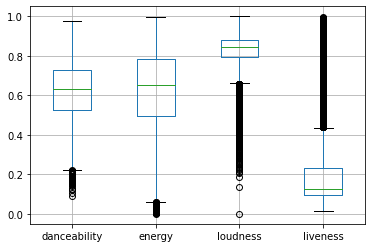

In [7]:
raw_data.boxplot(column=['danceability', 'energy', 'loudness', 'liveness'])


<AxesSubplot:>

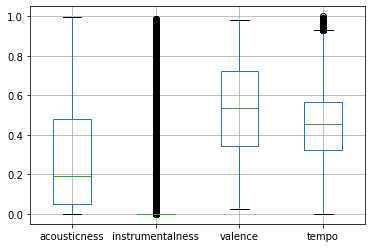

In [8]:
raw_data.boxplot(column=['acousticness', 'instrumentalness', 'valence', 'tempo'])


<AxesSubplot:>

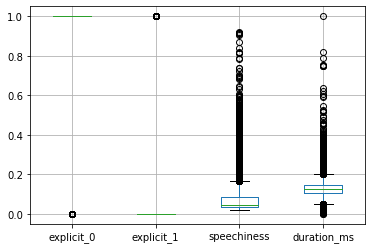

In [9]:
raw_data.boxplot(column=['explicit_0', 'explicit_1', 'speechiness', 'duration_ms'])


<AxesSubplot:>

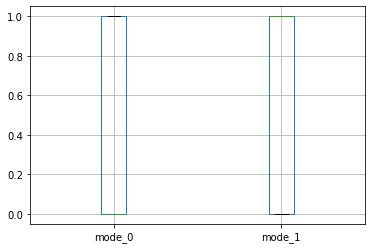

In [10]:
raw_data.boxplot(column=['mode_0', 'mode_1'])


<AxesSubplot:>

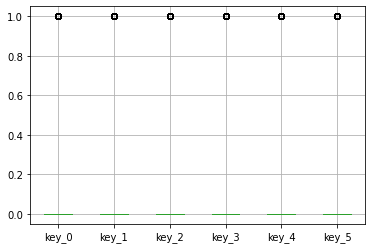

In [11]:
raw_data.boxplot(column=['key_0', 'key_1', 'key_2', 'key_3', 'key_4', 'key_5'])

<AxesSubplot:>

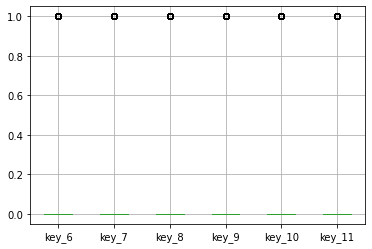

In [12]:
raw_data.boxplot(column=['key_6', 'key_7', 'key_8', 'key_9', 'key_10', 'key_11', ])

<AxesSubplot:>

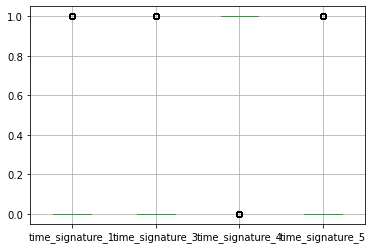

In [13]:
raw_data.boxplot(column=['time_signature_1', 'time_signature_3', 'time_signature_4','time_signature_5'])


## Analyze data for correlated features

In [14]:
subplots = 1

def plotCorrMat(title, corMat, save=True):
    fig = plt.figure(figsize=(15,15),dpi=200)
    sb.heatmap(corMat, annot = False)
    plt.title("{} Corr Matrix".format(title))
    
    if save:
        plt.savefig("Images/{}_CorrMat.png".format(title))
    
    plt.show()

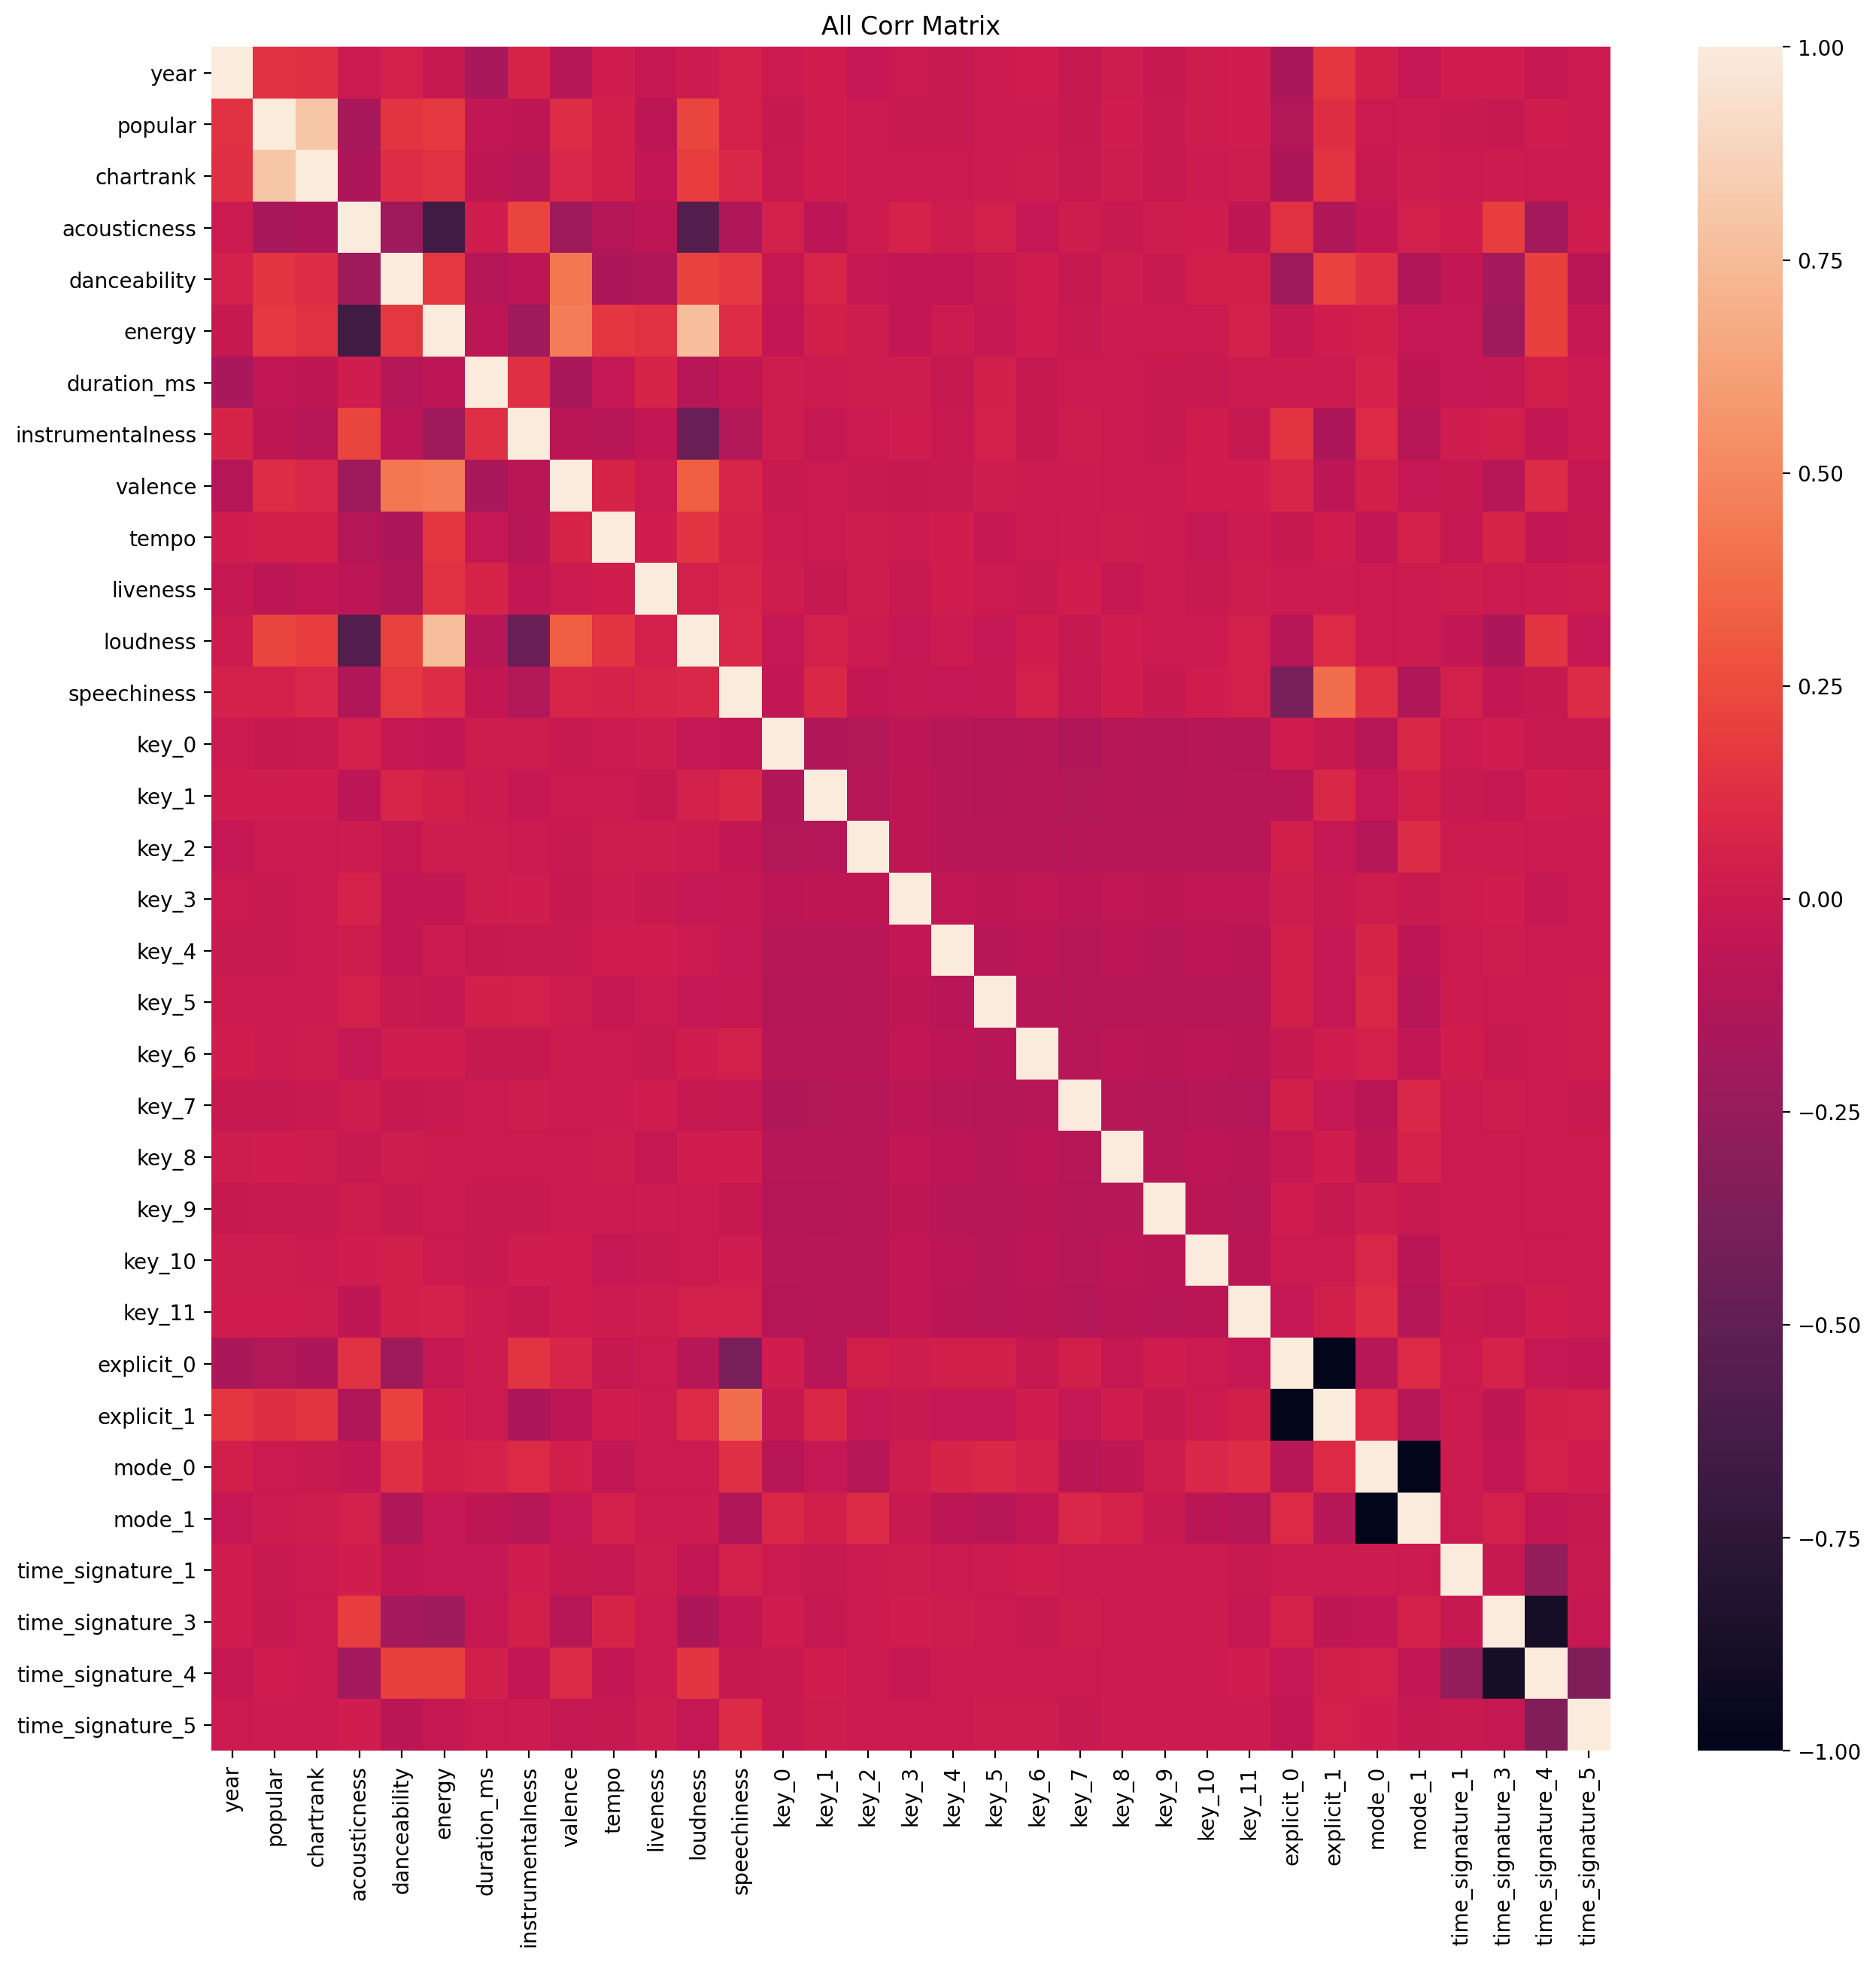

In [15]:
plotCorrMat("All", raw_data.corr())

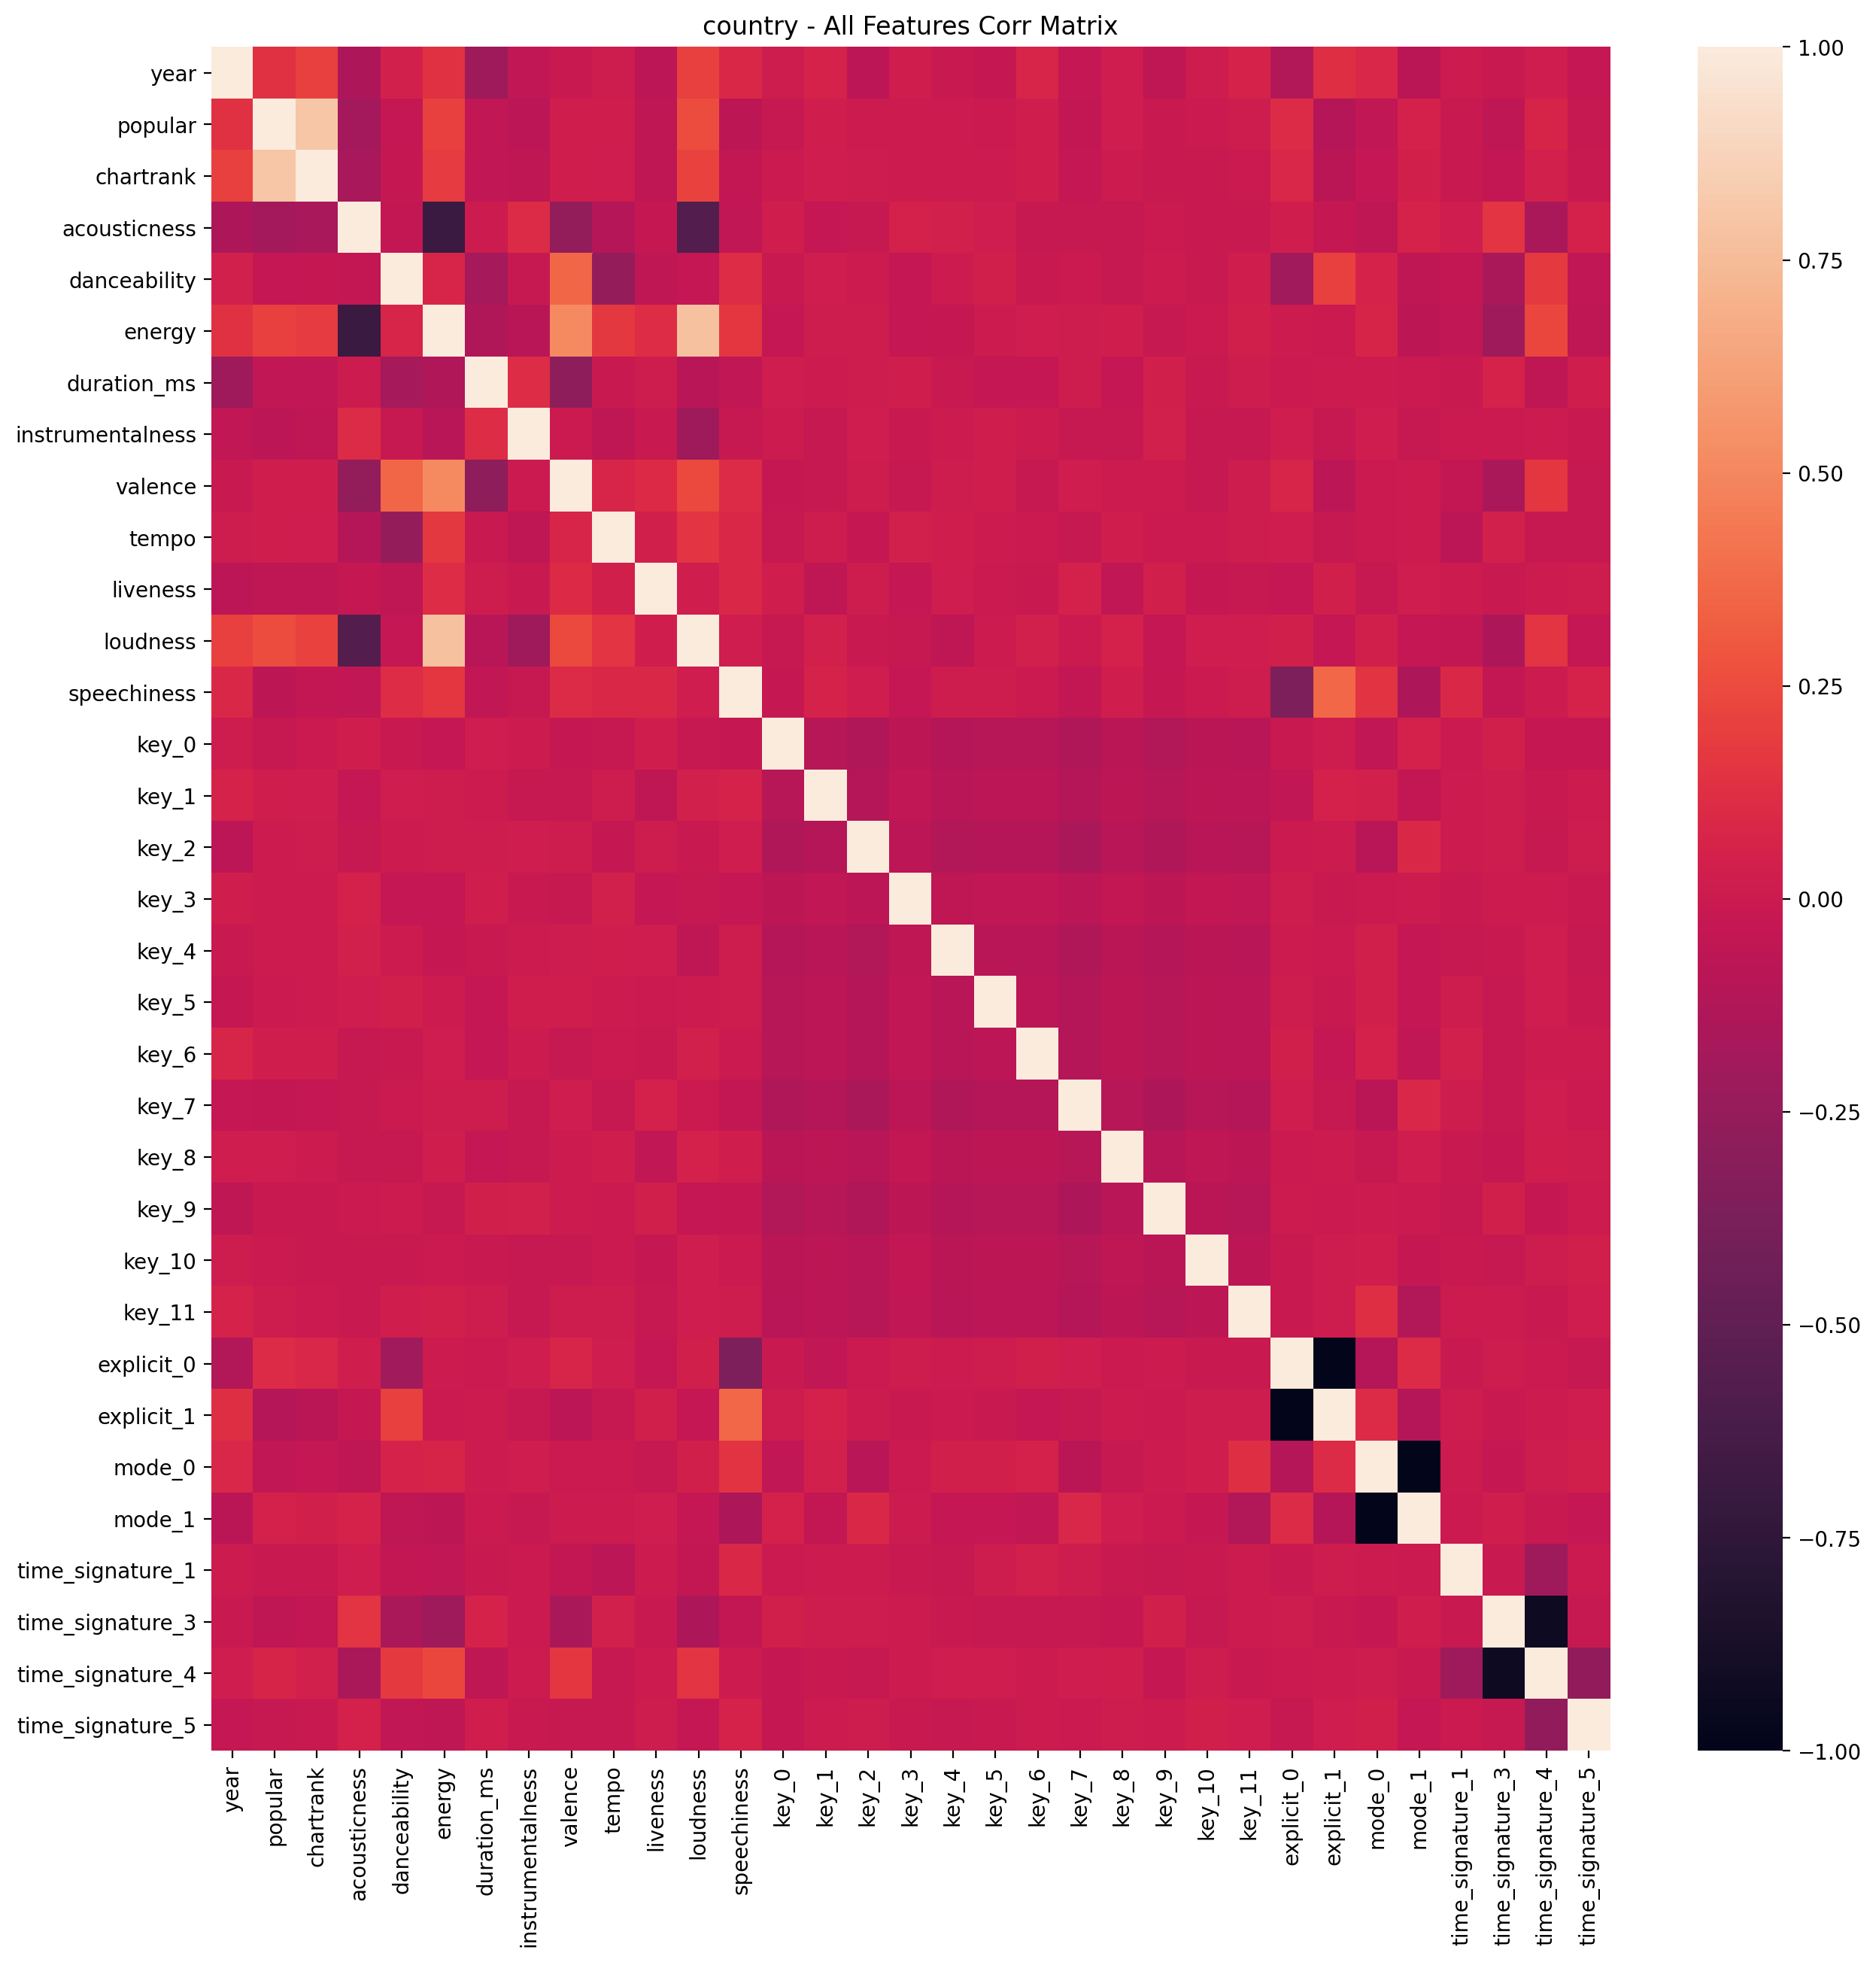

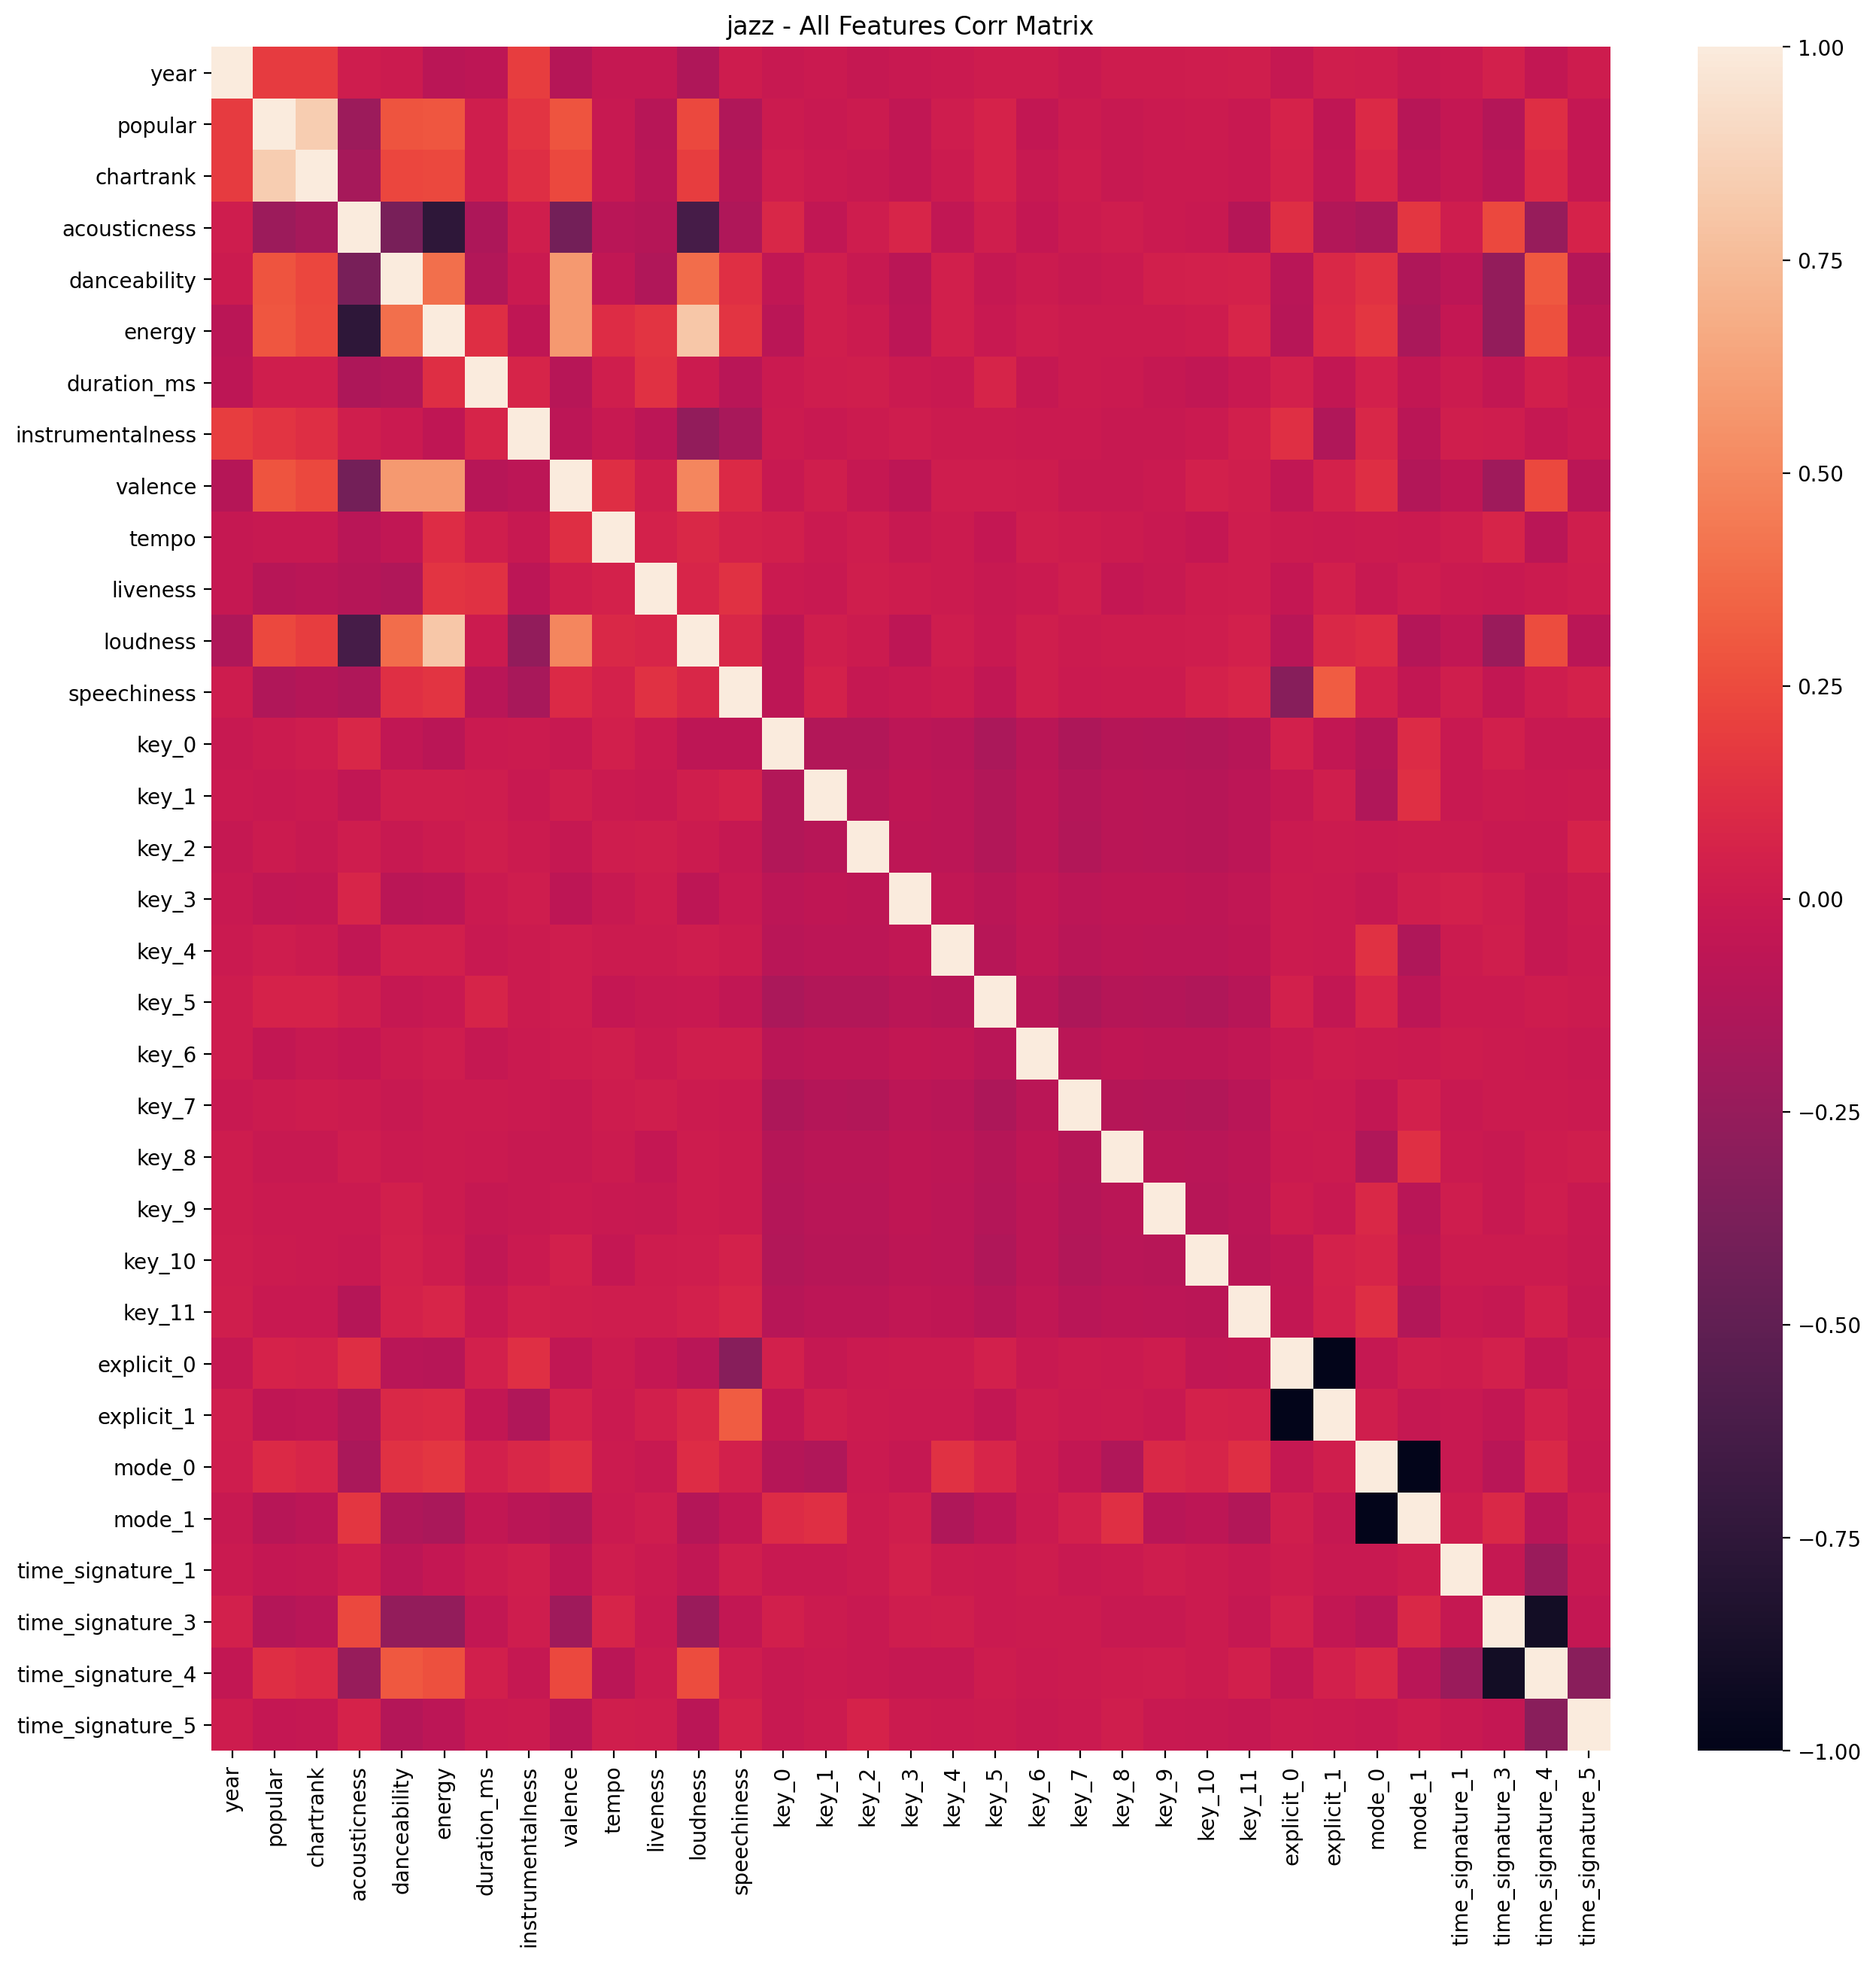

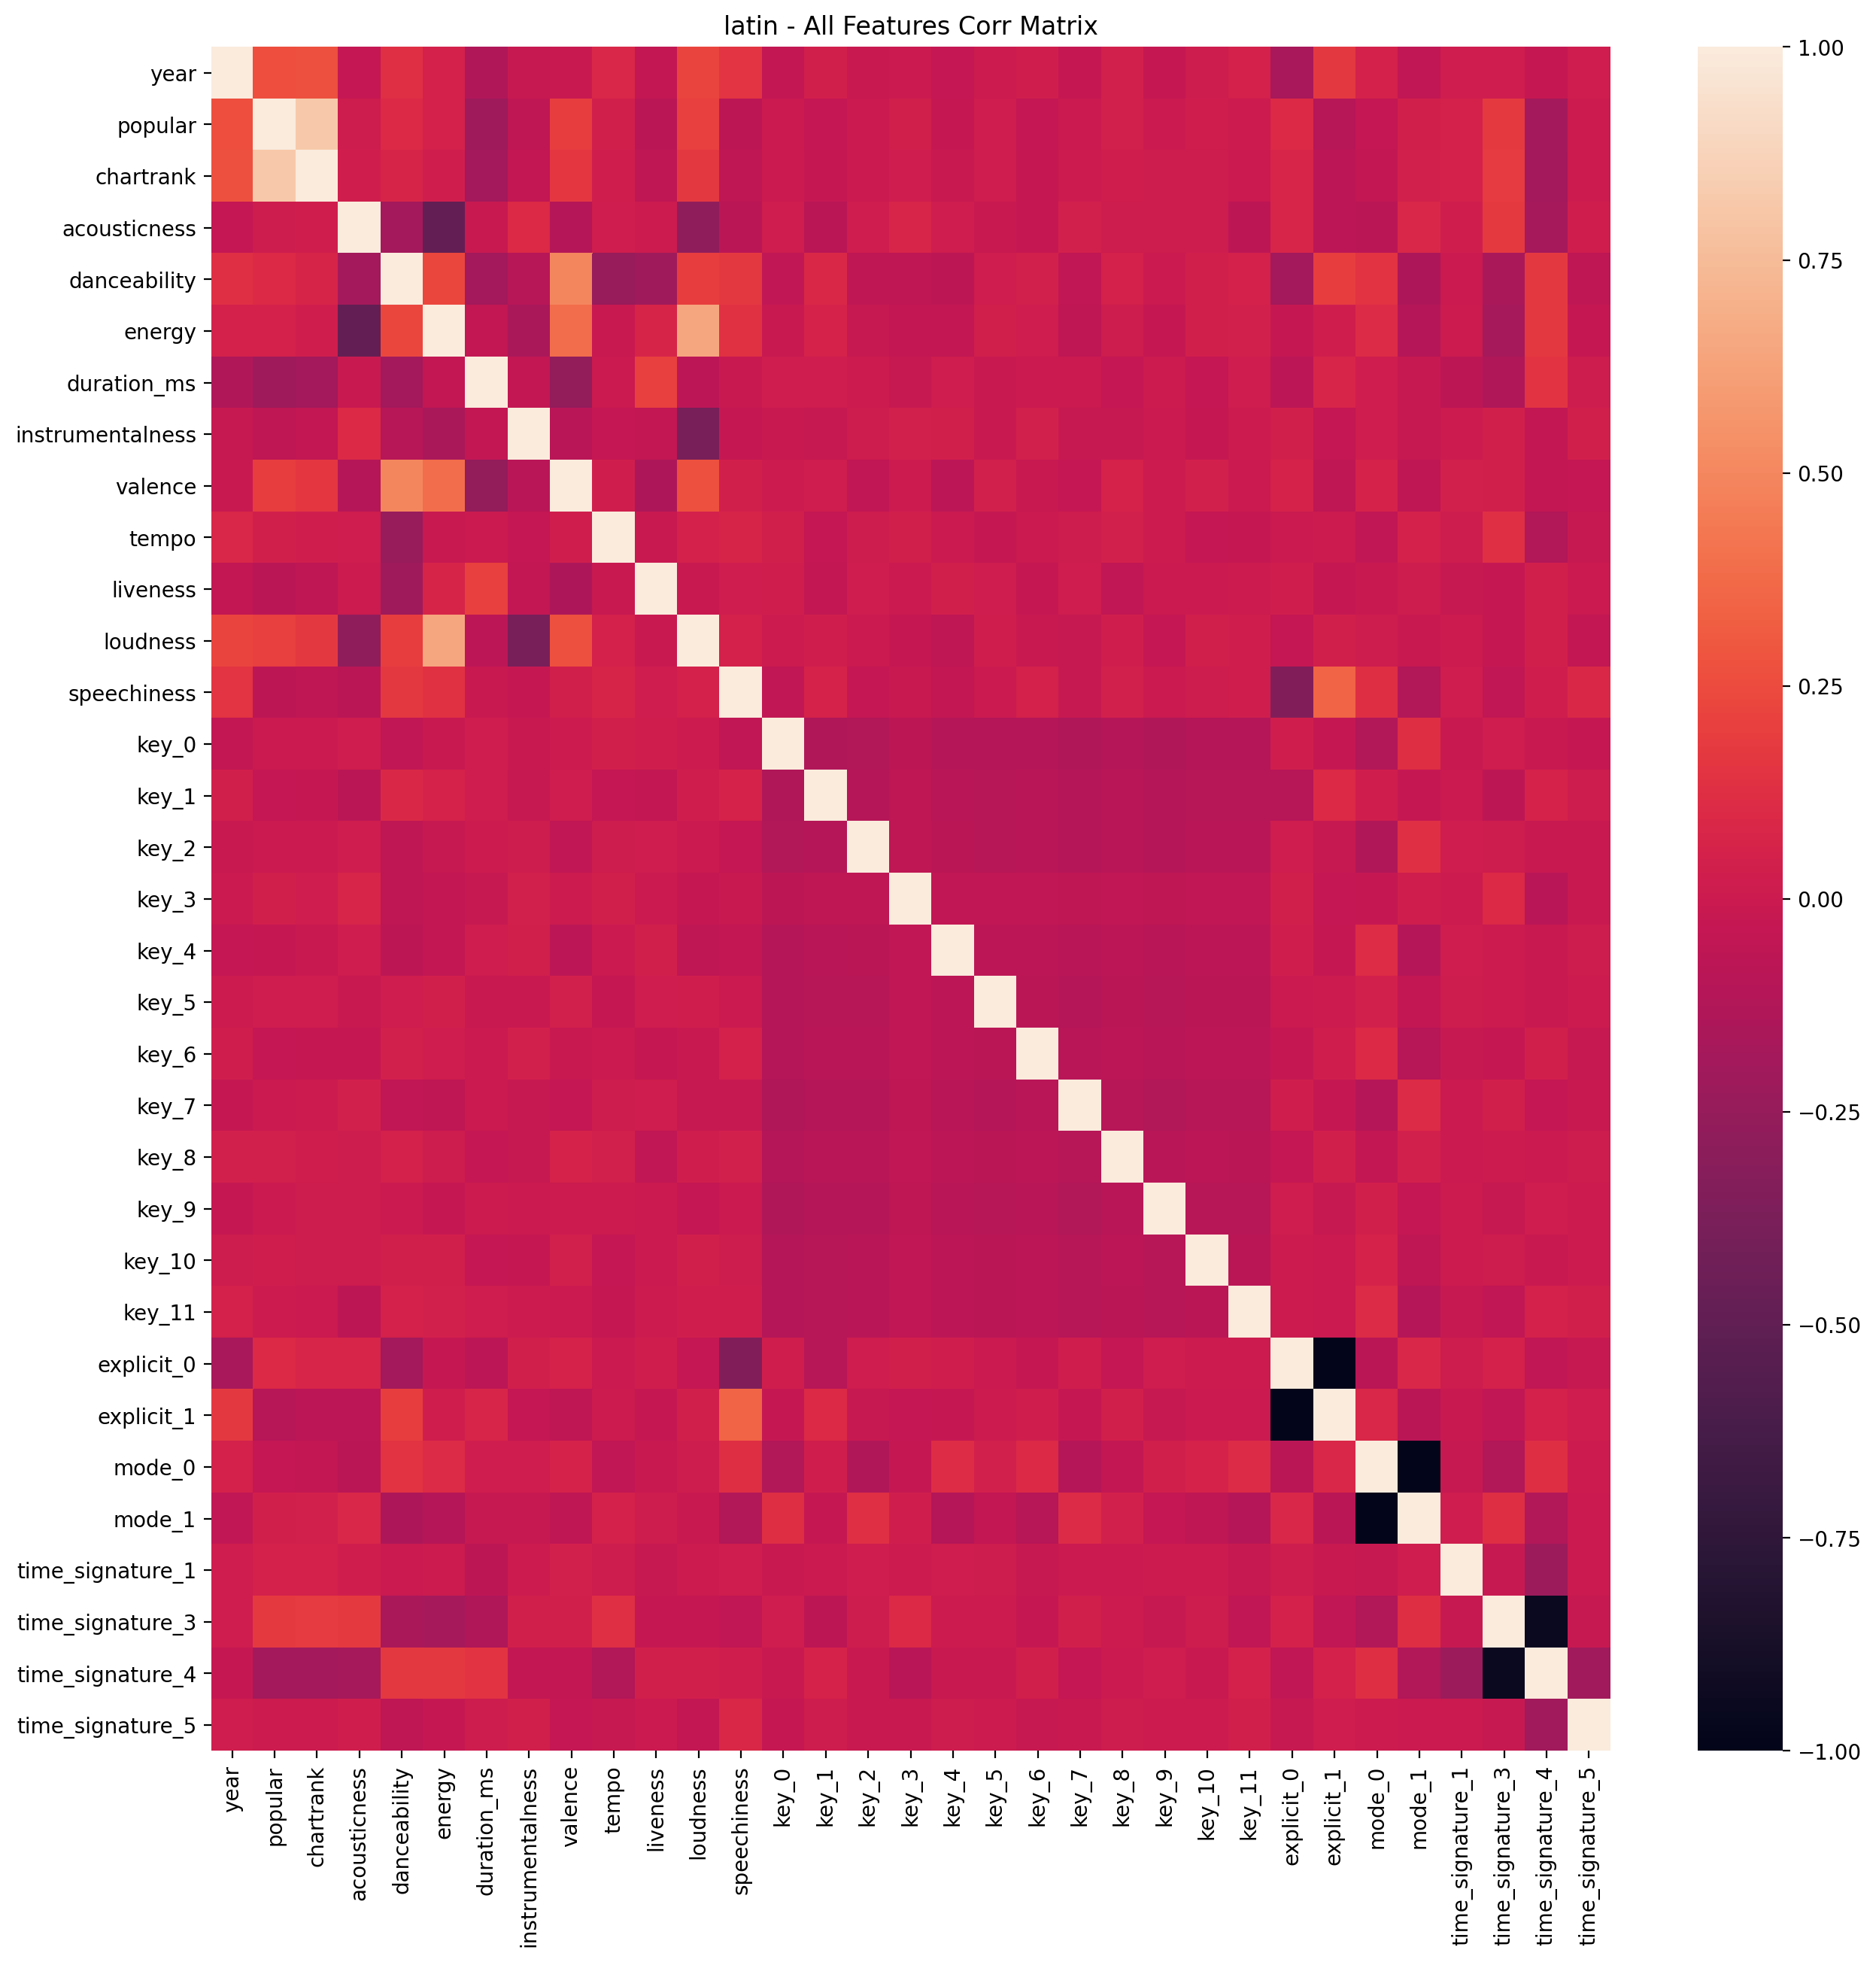

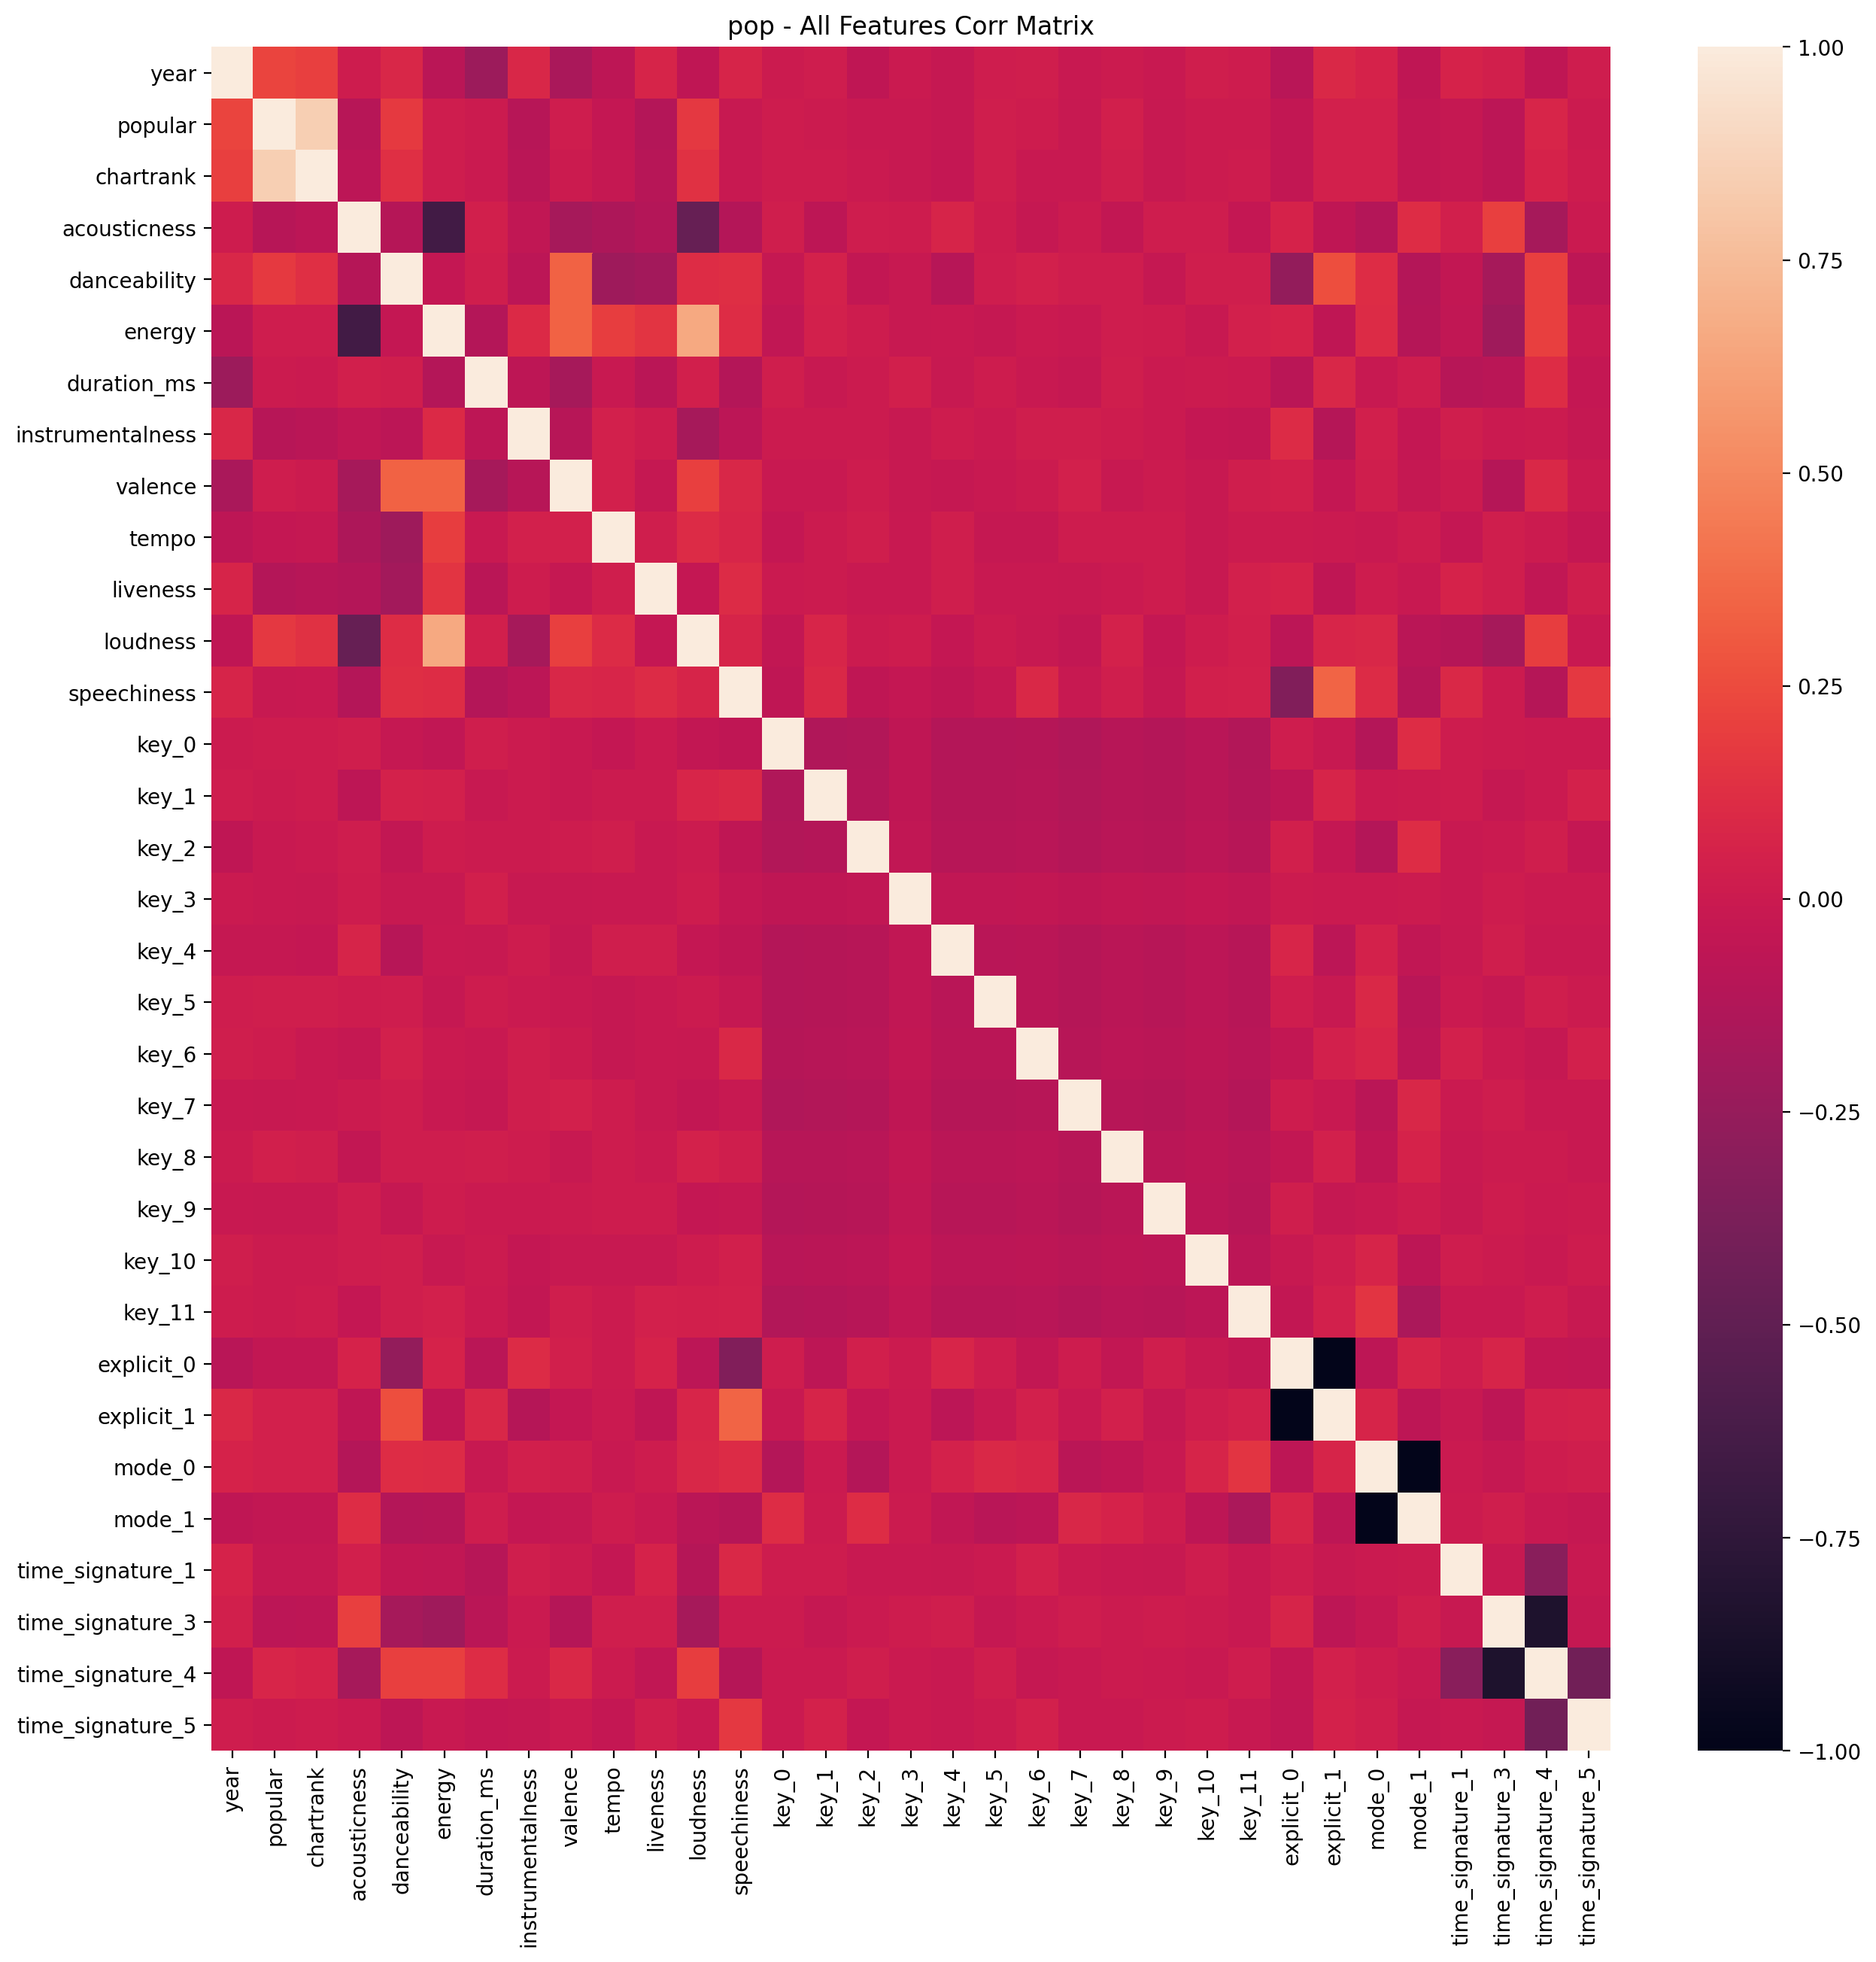

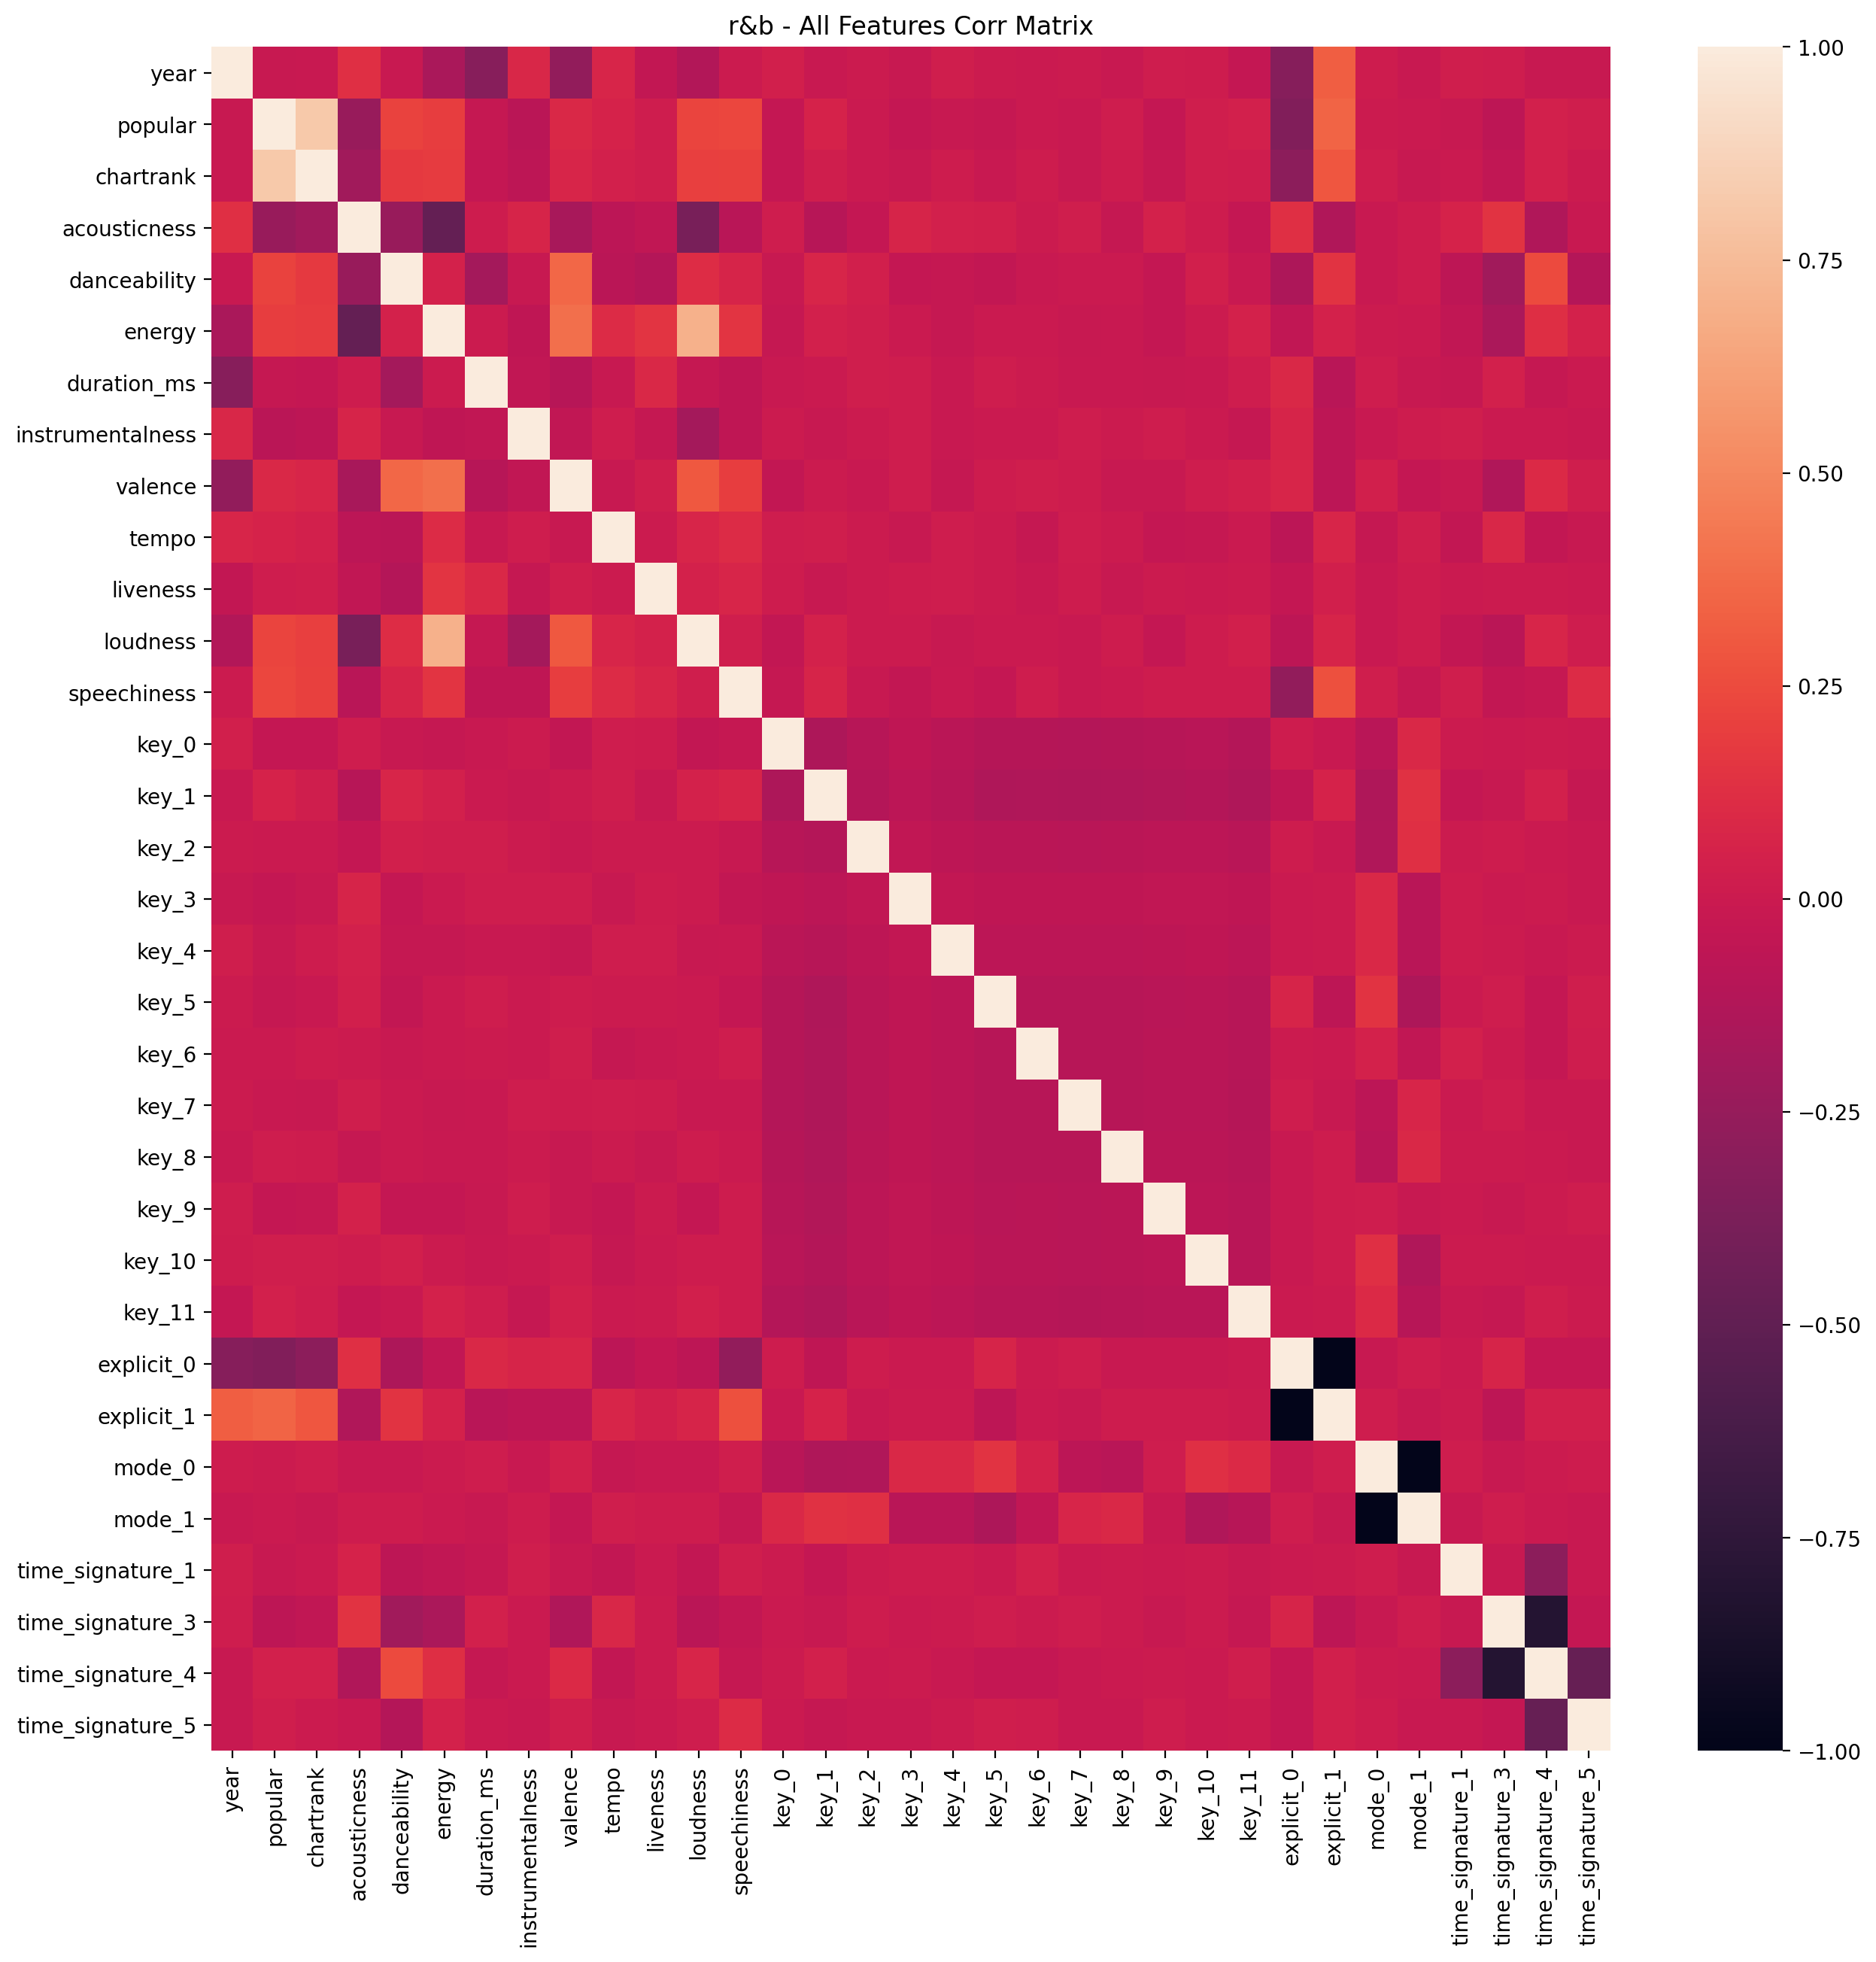

In [16]:
data_by_genre = raw_data.groupby('genre')

for name, obj in data_by_genre.__iter__():
    plotCorrMat(name + ' - All Features', obj.corr())

We didn't find many features that are significantly correlated to "popularity" other than "chartrank", but that "chartrank" feature is expected to be correlated and therefore not insightful in this case. 

Some stronger correlations to note:
 - energy/loudness to acousticness (negative)
   - This makes sense, since acoustic songs are typically lower energy and softer than non-acoustic counterparts
 - energy to loudness
   - Higher energy songs tend to be louder
 - loudness to instrumentalness (negative)
   - This is an interesting correlation since it would be assumed less singing in a song would not contribute to it being quieter
 - explicit to speechiness
   - Speechiness would be considered spoken word/rap songs at high values, so a higher explicit average also makes sense
 - energy to valence for country songs
   - valence is higher for more 'positive' sounding tracks. Higher energy tracks are typically more positive

We notice ("popularity", "chartrank") & ("energy", "loudness") correlations are present everywhere, so we will omit its mention any further in the analysis of the genre feature correlations below.

The Jazz genre's "valence" & "danceability" features are somewhat correlated. There's a correlation between the "valence" & "energy" features; "energy" & "acousticness"; "loudness" & "acousticness".

Pop genre correlations: "energy" & "acousticness".

Country genre correlation between the "valence" and "energy" features;  "energy" & "acousticness"; "loudness" & "acousticness".

# Classification

### Use Feature Selection methods to determine which features are most important to determining popularity of the song per genre

Since we know chart rank is correlated to popularity, and we want to base our predictions based on song features, we will drop the 'chartrank' column from our training data

In [19]:
data_copy = raw_data.drop(columns=['chartrank'])

Training data will consist of songs prior to 2019, a total of 20,618 tracks.  Test data will consist of songs in 2019 & 2020, summing up to 2,509 tracks.  Roughly 12% of our raw data is for testing.  Our target will be predicting 'popular' or 'unpopular'.

In [20]:
train_matrix = data_copy[data_copy['year'] < 2019]
train_target = train_matrix.pop("popular")
test_matrix = data_copy[data_copy['year'] >= 2019]
test_target = test_matrix.pop("popular")

# Testing on all genres
train_all = train_matrix.drop(columns=["genre"])
test_all = test_matrix.drop(columns=['genre'])

In [21]:
data_by_genre = data_copy.groupby('genre')

genre_names = []
genres_train = []  # dataframes per genre for years < 2019
genres_train_targets = []
genres_test = []   # dataframes per genre for year >= 2019
genres_test_targets = []

for name, obj in data_by_genre.__iter__():
    print("Genre: ", name)
    genre_names.append(name)
    # Drop "genre" column because we want to train/test on numerical values only
    copy_genre_matrix = obj.drop(columns=['genre'])
    # Split training & testing data based on year 
    genre_train = copy_genre_matrix[copy_genre_matrix['year'] < 2019]
    genre_test = copy_genre_matrix[copy_genre_matrix['year'] >= 2019]
    # Separate target column
    genre_train_target = genre_train.pop('popular')
    genre_test_target  = genre_test.pop('popular')
    # Gather newly created training & testing datasets
    genres_train.append(genre_train)
    genres_train_targets.append(genre_train_target)
    genres_test.append(genre_test)
    genres_test_targets.append(genre_test_target)
        

Genre:  country
Genre:  jazz
Genre:  latin
Genre:  pop
Genre:  r&b


Multiple methods will be implemented to test the parameters that yield the highest accuracy per model, as well as visualize the cross-validation score on a more granular level: per-parameter basis.

In [22]:
def plot_params(param_values, param_name, train_scores, test_scores):
    # plot the training and testing scores in a log scale
    plt.plot(param_values, train_scores, label='Train', alpha=0.4, lw=2, c='b')
    plt.plot(param_values, test_scores, label='X-Val', alpha=0.4, lw=2, c='g')
    plt.legend(loc=7)
    plt.xlabel(param_name + " values")
    plt.ylabel("Mean cross validation accuracy")

In [23]:
def best_params(x, y, model, params, scoring, k):
    grid = GridSearchCV(estimator=model, param_grid=params, scoring=scoring, cv=k, return_train_score=True)
    grid.fit(x, y)

    return grid

In [24]:
def plot_best_param(x, y, model, param_name, param_values, k):
    params = dict([(param_name, param_values)])
    grid = GridSearchCV(model, param_grid=params, cv=k, n_jobs=-1, return_train_score=True)
    grid.fit(x, y)
    print(grid.best_params_)
    plot_params(param_values, param_name, grid.cv_results_['mean_train_score'], grid.cv_results_['mean_test_score'])
    

## Decision Trees
One of the easiest and most efficient ways to determine feature selection is by using Decision Trees.  We will start by analyzing all the features for all the tracks.  Then, we will test different parameters and will use the parameters that yield the highest accuracy on our model.  Finally, we will see if we could improve our accuracy by repeating this process on a more granular level - separating tracks by genre.

In [25]:
treeclf = tree.DecisionTreeClassifier()
depths = np.arange(1, 15)
splits_parent = np.arange(20, 200, 20)
splits_leaf = np.arange(5, 100, 5)
scoring = 'accuracy'
kfold = 5

parameters = {
    'criterion': ['gini', 'entropy'],
    'max_depth': depths,
    'min_samples_split': splits_parent,
    'min_samples_leaf': splits_leaf
}

# WARNING: Takes several minutes to generate
grid = best_params(train_all, train_target, treeclf, parameters, scoring, kfold)


In [26]:
grid.best_params_

{'criterion': 'gini',
 'max_depth': 1,
 'min_samples_leaf': 5,
 'min_samples_split': 20}

In [27]:
pd.DataFrame(grid.cv_results_)

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0          0.040217      0.026326         0.004808        0.002883   
1          0.023604      0.000109         0.003118        0.000076   
2          0.024102      0.000452         0.003109        0.000040   
3          0.029805      0.001000         0.003644        0.000207   
4          0.027153      0.002085         0.003424        0.000410   
...             ...           ...              ...             ...   
4783       0.178887      0.013206         0.003761        0.000290   
4784       0.164501      0.013364         0.003461        0.000082   
4785       0.187504      0.025161         0.003696        0.000234   
4786       0.172507      0.011668         0.004068        0.000558   
4787       0.164564      0.008863         0.003450        0.000178   

     param_criterion param_max_depth param_min_samples_leaf  \
0               gini               1                      5   
1               gini               1                      5   
2               gini               1                      5   
3               gini               1                      5   
4               gini               1                      5   
...              ...             ...                    ...   
4783         entropy              14                     95   
4784         entropy              14                     95   
4785         entropy              14                     95   
4786         entropy              14                     95   
4787         entropy              14                     95   

     param_min_samples_split  \
0                         20   
1                         40   
2                         60   
3                         80   
4                        100   
...                      ...   
4783                     100   
4784                     120   
4785                     140   
4786                     160   
4787                     180   

                                                 params  split0_test_score  \
0     {'criterion': 'gini', 'max_depth': 1, 'min_sam...           0.763094   
1     {'criterion': 'gini', 'max_depth': 1, 'min_sam...           0.763094   
2     {'criterion': 'gini', 'max_depth': 1, 'min_sam...           0.763094   
3     {'criterion': 'gini', 'max_depth': 1, 'min_sam...           0.763094   
4     {'criterion': 'gini', 'max_depth': 1, 'min_sam...           0.763094   
...                                                 ...                ...   
4783  {'criterion': 'entropy', 'max_depth': 14, 'min...           0.663434   
4784  {'criterion': 'entropy', 'max_depth': 14, 'min...           0.663434   
4785  {'criterion': 'entropy', 'max_depth': 14, 'min...           0.663434   
4786  {'criterion': 'entropy', 'max_depth': 14, 'min...           0.663434   
4787  {'criterion': 'entropy', 'max_depth': 14, 'min...           0.663434   

      split1_test_score  split2_test_score  split3_test_score  \
0              0.763094           0.763094           0.763279   
1              0.763094           0.763094           0.763279   
2              0.763094           0.763094           0.763279   
3              0.763094           0.763094           0.763279   
4              0.763094           0.763094           0.763279   
...                 ...                ...                ...   
4783           0.685984           0.715325           0.626728   
4784           0.685984           0.715325           0.626728   
4785           0.685984           0.715325           0.626728   
4786           0.685984           0.715325           0.626728   
4787           0.685984           0.715325           0.626728   

      split4_test_score  mean_test_score  std_test_score  rank_test_score  \
0              0.763037         0.763120        0.000083                1   
1              0.763037         0.763120        0.000083                1   
2              0.763037         0.763120        0.000083                1 

Though we were able to get the best parameters all at once, let's plot one of those parameter ranges to 
1. better understand the reasoning behind our model's selection; and
2. confirm there aren't better parameters to choose from.

For now, let's plot the cross-validation against the max depth parameter range.

Later we'll plot the other 2 parameter ranges: min samples split & min samples leaf.

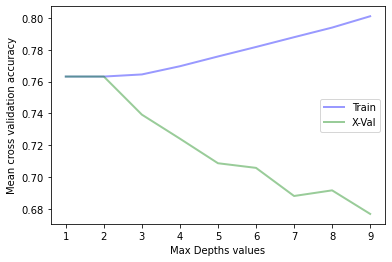

In [28]:
depths2 = np.arange(1, 10)
treeclf2 = tree.DecisionTreeClassifier(criterion='gini', min_samples_split=20, min_samples_leaf=5)
parameters2 = {
    'max_depth': depths2
}
grid2 = GridSearchCV(estimator=treeclf2, param_grid=parameters2, n_jobs=-1, cv=5, return_train_score=True)
grid2.fit(train_all, train_target)
plot_params(depths2, 'Max Depths', grid2.cv_results_['mean_train_score'], grid2.cv_results_['mean_test_score'])


In [29]:
grid2.best_params_

{'max_depth': 1}

The plot suggests that a max-depth of 1 is sufficient for returning the highest accuracy.  We need to find out which feature the DT is splitting on and analyze its merits.  Let's create a Decision Tree model with the suggested min_samples_split & min_samples_leaf values, & set the max_depth at the 3rd highest accuracy rate to get more variance.  Them, we'll analyze the classification report to determine how well our model is doing in both precision and recall using those "best" parameters.

In [30]:
dt_all = tree.DecisionTreeClassifier(criterion='entropy', max_depth=7, min_samples_split=140, min_samples_leaf=20)
dt_all.fit(train_all, train_target)
print(dt_all.score(train_all, train_target))

0.7725773595887089


In [31]:
dt_all = tree.DecisionTreeClassifier(criterion='entropy', max_depth=7, min_samples_split=20, min_samples_leaf=5)
dt_all.fit(train_all, train_target)
print(dt_all.score(train_all, train_target))

0.772868367445921


In [32]:
dt_all_pred = dt_all.predict(test_all)
print(classification_report(test_target, dt_all_pred))


              precision    recall  f1-score   support

           0       0.70      0.99      0.82      1739
           1       0.74      0.06      0.12       770

    accuracy                           0.71      2509
   macro avg       0.72      0.53      0.47      2509
weighted avg       0.72      0.71      0.61      2509



As we can see from our low recall score for classifying 'popular', our decision tree model performs worse than randomly guessing at predicting popular track features.  The 71% accuracy stems from it's better ability to predict unpopular tracks.

In [33]:
treecm = confusion_matrix(test_target, dt_all_pred)
treecm

array([[1722,   17],
       [ 721,   49]])

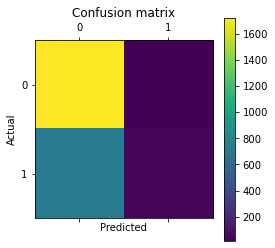

In [34]:
%matplotlib inline
plt.matshow(treecm)
plt.title('Confusion matrix')
plt.colorbar()
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

Let's see which features were used in our Decision Tree model.

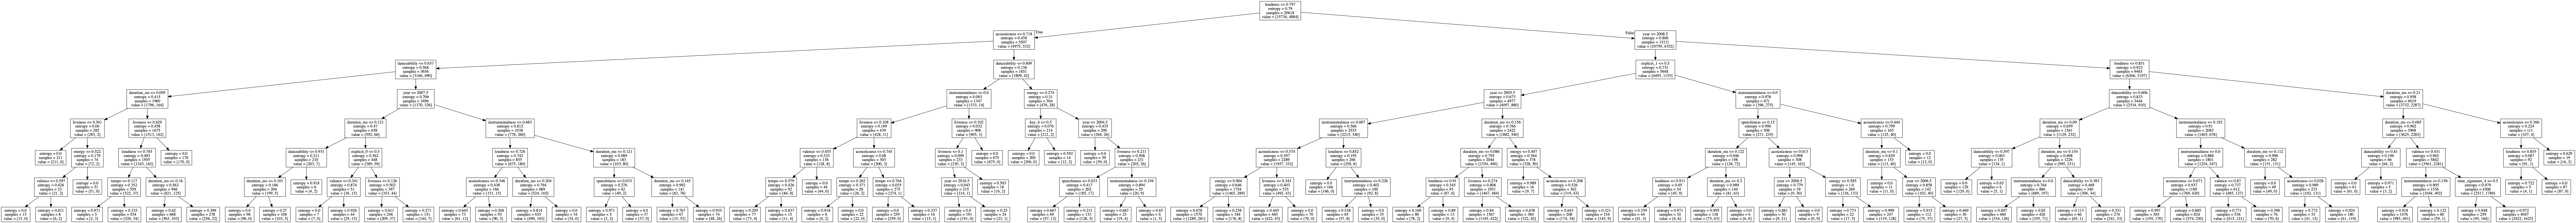

In [35]:
def display_model(dot_filename, png_filename, model, columns):
    export_graphviz(model, out_file=dot_filename, feature_names=columns)
    # system(dot -Tpng DT_all_genres.dot -o dtree.png)
    %alias sys_syntax dot -Tpng %s -o %s
    %sys_syntax $dot_filename $png_filename
    return Image(filename=png_filename, width=800)
    
display_model('DT_all_genres.dot', 'dtree.png', dt_all, train_all.columns)

In [36]:
dt_all.n_features_

31

Based on all the genres and all the features, our Decision Tree selected 'loudness' as the most informational feature to split on.  In the 2nd level, it split on 'acousticness' and 'year'. We can dismiss the 'year' feature since our data aims to predict popularity based on audio features. At the 3rd level, it splits on 'explicit_1', 'danceability', and 'loudness' again.

Using these best params, we can next test on max_features and assign a min_impurity_decrease value to help prune off features that don't return more information.


In [37]:
dt_pruned = tree.DecisionTreeClassifier(criterion='gini', min_samples_split=20, min_samples_leaf=5)
depths = np.arange(1, 7)
n_features = np.arange(1, 15)
split_on_impurity = [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

parameters = {
    'max_depth': depths,
    'max_features': n_features,
    'min_impurity_decrease': split_on_impurity
}

dt_grid2 = best_params(train_all, train_target, dt_pruned, parameters, scoring, kfold)


In [38]:
dt_grid2.best_params_

{'max_depth': 1, 'max_features': 1, 'min_impurity_decrease': 0.01}

Let's see if our Decision Tree model improves if we fit it on a per-genre basis.  We will re-evaluate the previous parameters in order to better fit our smaller datasets.  First, we'll observe each parameter range individually for cross-validation scores.  Then we'll test on all the parameters to get the best combination of parameters.

{'max_depth': 2}


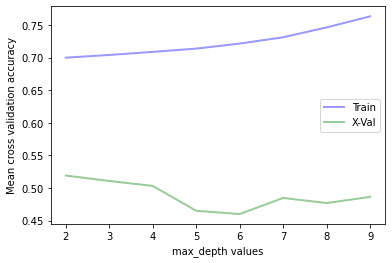

In [39]:
genre_dt = tree.DecisionTreeClassifier(criterion='gini')
depths = np.arange(2,10)
plot_best_param(genres_train[0], genres_train_targets[0], genre_dt, 'max_depth', depths, 10)


{'max_depth': 2}


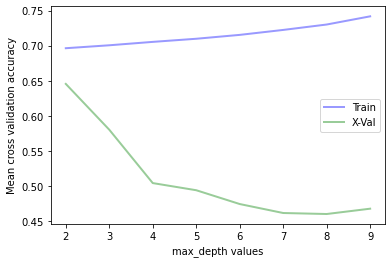

In [40]:
genre_dt = tree.DecisionTreeClassifier(criterion='entropy')
depths = np.arange(2,10)
plot_best_param(genres_train[0], genres_train_targets[0], genre_dt, 'max_depth', depths, 10)


{'min_samples_split': 10}


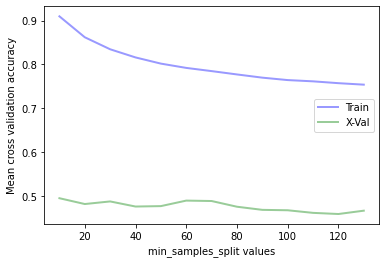

In [41]:
genre_dt = tree.DecisionTreeClassifier(criterion='entropy')
splits_parent = np.arange(10, 140, 10)
plot_best_param(genres_train[0], genres_train_targets[0], genre_dt, 'min_samples_split', splits_parent, 10)


{'min_samples_leaf': 11}


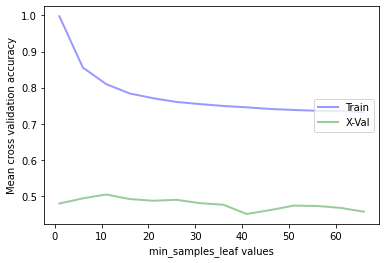

In [42]:
splits_leaf = np.arange(1, 70, 5)
plot_best_param(genres_train[0], genres_train_targets[0], genre_dt, 'min_samples_leaf', splits_leaf, 10)


In [43]:
depths = np.arange(1, 7)
splits_parent = np.arange(10, 100, 10)
splits_leaf = np.arange(1, 40, 5)

parameters = {
    'max_depth': depths,
    'min_samples_split': splits_parent,
    'min_samples_leaf': splits_leaf
}

grid = best_params(genres_train[0], genres_train_targets[0], genre_dt, parameters, scoring, kfold)


In [44]:
grid.best_params_

{'max_depth': 1, 'min_samples_leaf': 1, 'min_samples_split': 10}

In [45]:
depths = np.arange(1, 5)
n_features = np.arange(1, 5)
split_on_impurity = [0.01, 0.05, 0.1, 0.2]
splits_parent = np.arange(5, 105, 25)
splits_leaf = np.arange(1, 40, 5)

parameters = {
    'max_depth': depths,
    'min_samples_split': splits_parent,
    'min_samples_leaf': splits_leaf,
    'max_features': n_features,
    'min_impurity_decrease': split_on_impurity
}

dt_grid3 = best_params(genres_train[0], genres_train_targets[0], genre_dt, parameters, scoring, kfold)


In [46]:
dt_grid3.best_params_

{'max_depth': 1,
 'max_features': 1,
 'min_impurity_decrease': 0.01,
 'min_samples_leaf': 1,
 'min_samples_split': 5}

Genre:  country
Number of features used:  15
              precision    recall  f1-score   support

           0       0.62      1.00      0.77       321
           1       0.00      0.00      0.00       197

    accuracy                           0.62       518
   macro avg       0.31      0.50      0.38       518
weighted avg       0.38      0.62      0.47       518



/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


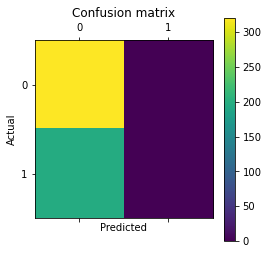

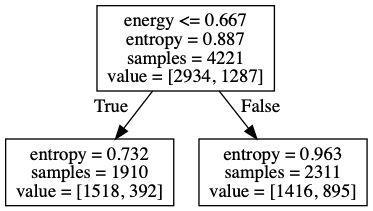

Genre:  jazz
Number of features used:  15
              precision    recall  f1-score   support

           0       0.79      1.00      0.88       357
           1       0.00      0.00      0.00        96

    accuracy                           0.79       453
   macro avg       0.39      0.50      0.44       453
weighted avg       0.62      0.79      0.69       453



/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


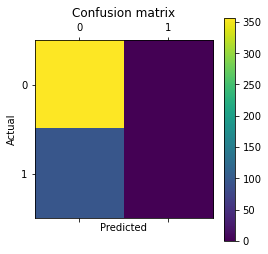

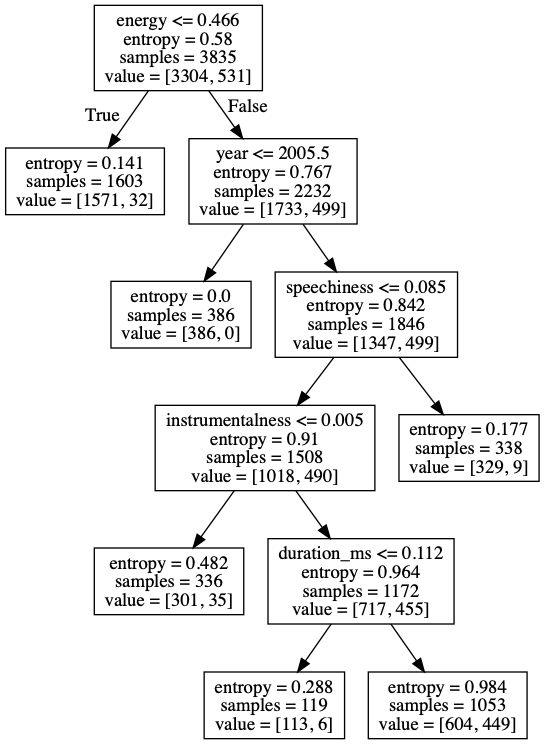

Genre:  latin
Number of features used:  15
              precision    recall  f1-score   support

           0       0.64      1.00      0.78       325
           1       0.90      0.05      0.09       188

    accuracy                           0.65       513
   macro avg       0.77      0.52      0.44       513
weighted avg       0.74      0.65      0.53       513



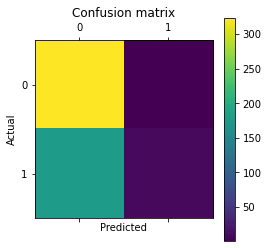

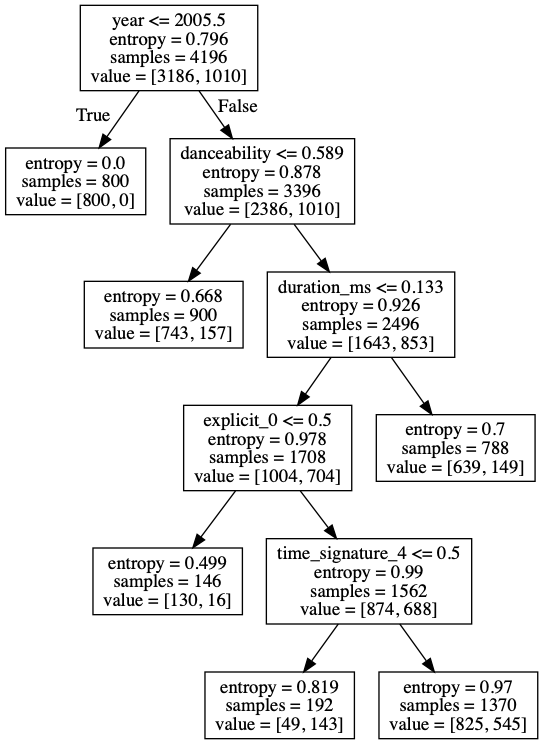

Genre:  pop
Number of features used:  15
              precision    recall  f1-score   support

           0       0.78      1.00      0.88       353
           1       0.00      0.00      0.00        97

    accuracy                           0.78       450
   macro avg       0.39      0.50      0.44       450
weighted avg       0.62      0.78      0.69       450



/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


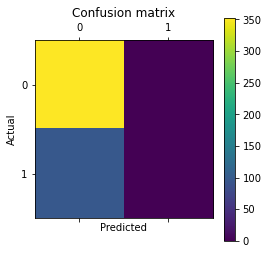

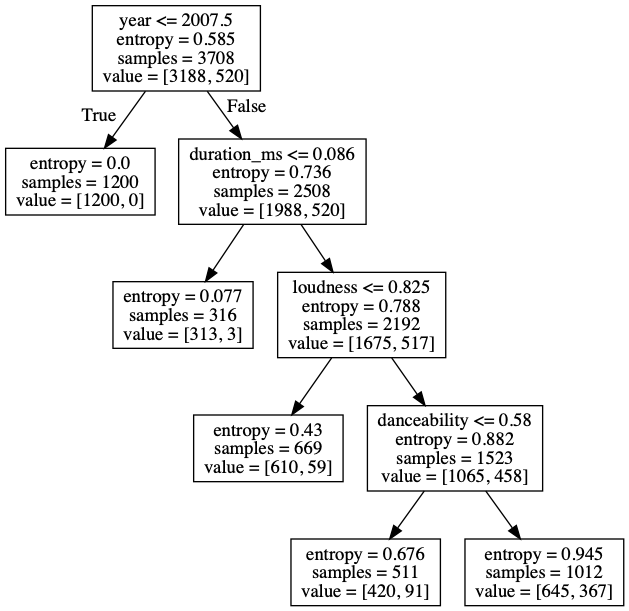

Genre:  r&b
Number of features used:  15
              precision    recall  f1-score   support

           0       0.88      0.73      0.80       383
           1       0.60      0.80      0.68       192

    accuracy                           0.75       575
   macro avg       0.74      0.77      0.74       575
weighted avg       0.79      0.75      0.76       575



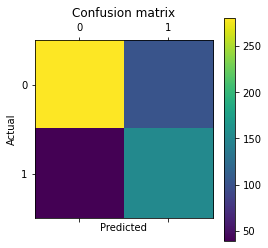

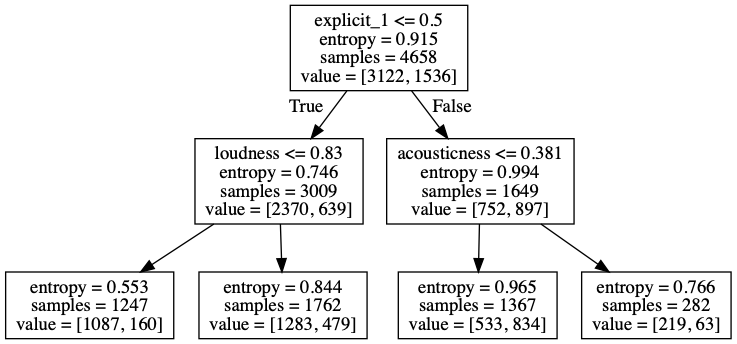

In [47]:
for name, obj in data_by_genre.__iter__():
    print("Genre: ", name)
    # Create a copy of the df
    copy_genre_matrix = pd.DataFrame(obj, copy=True)
    # Drop "genre" column because we want to train/test on numerical values only
    copy_genre_matrix = copy_genre_matrix.drop(columns=['genre'])
    # Split training & testing data based on year 
    genre_train = copy_genre_matrix[copy_genre_matrix['year'] < 2019]
    genre_test = copy_genre_matrix[copy_genre_matrix['year'] >= 2019]
    # Separate target column
    genre_train_target = genre_train.pop('popular')
    genre_test_target  = genre_test.pop('popular')
    # Create a classifier with the best params
    dt_per_genre = tree.DecisionTreeClassifier(criterion='entropy', max_depth=5, min_samples_split=5, min_samples_leaf=1, min_impurity_decrease=0.01, max_features=0.5)
    # Fit the classifier with our data per genre
    dt_per_genre.fit(genre_train, genre_train_target)
    print("Number of features used: ", dt_per_genre.max_features_)

    # Predict on test set
    dt_predict_per_genre = dt_per_genre.predict(genre_test)
    #print("Predictions on test set:")
    #display(dt_predict_per_genre)
    # Analyze how well our Decision Tree can predict popularity
    print(classification_report(genre_test_target, dt_predict_per_genre))
    # Confusion matrix
    dt_genre_cm = confusion_matrix(genre_test_target, dt_predict_per_genre)
    # Plot the confusion matrix
    %matplotlib inline
    plt.matshow(dt_genre_cm)
    plt.title('Confusion matrix')
    plt.colorbar()
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()
    
    # Display Tree
    if name == "r&b":
        name = "rnb"
    dot_filename = f'{name}_DT.dot'
    png_filename = f'{name}_tree.png'
    display(display_model(dot_filename, png_filename, dt_per_genre, genre_train.columns))

    

- The DT for the 'Country' genre failed to predict any potentially popular country tracks (precision = 0) and had a mediocre score for predicting unpopular tracks with a precision of 0.62.  The only feature it split on was on 'loudness'.
- Jazz failed to predict any potentially popular jazz tracks (precision = 0) and had a better score for predicting unpopular tracks with a precision of 0.79.  The jazz DT calculated 'energy', 'year', 'speechiness', 'danceability', & 'duration' as the features with the highest entropy.
- The Latin DT scored 65% on precision rate for unpopular predicted tracks & a 77% precision rate for predicted popular tracks.  However, the recall for predicting popularity is 9%, which means our model is not very accurate at detecting True Positives, & is therefore incomplete.  The features selected here were year, duration_ms, time_signature_4, & loudness. 
- Pop failed to predict any potentially popular pop tracks (precision = 0) and had a better score for predicting unpopular tracks with a precision of 0.78.  The features selected here were year, duration_ms, & loudness. 
- Finally, R&B had better luck with predictions with an 79% precision rate for unpopular tracks and 63% precision rate for predicted popular R&B tracks.  It's recall was 55% for predicted popular tracks, thus making it no better than a random 50/50 guessing.  The features selected here were explicit_0, speechiness, & acousticness.


Overall, our accuracy only improved in the Jazz, Pop, & R&B genres compared to the DT model based on all audio features across all genres.
Only in the R&B genre did we improve our recall score, which was still no better than guessing. 

## Naive Bayes

**Training on tracks across all genres for popularity**

In [48]:
# let's make a copy of train_all, test_all that drops the year column
train_all_no_year = pd.DataFrame(train_all, copy=True)
train_all_no_year = train_all_no_year.drop(columns=['year'])
test_all_no_year = pd.DataFrame(test_all, copy=True)
test_all_no_year = test_all_no_year.drop(columns=['year'])

# Create & fit our classifier
nb = naive_bayes.GaussianNB().fit(train_all_no_year, train_target)

# Get accuracy scores
print ("Score on Training: ", nb.score(train_all_no_year, train_target))
print ("Score on Test: ", nb.score(test_all_no_year, test_target))
nb_predict = nb.predict(test_all_no_year)
print(classification_report(test_target, nb_predict))

Score on Training:  0.624017848481909
Score on Test:  0.5914707054603427
              precision    recall  f1-score   support

           0       0.78      0.57      0.66      1739
           1       0.40      0.64      0.49       770

    accuracy                           0.59      2509
   macro avg       0.59      0.61      0.57      2509
weighted avg       0.66      0.59      0.61      2509



**Training on tracks per genres for popularity prediction**

In [49]:
for name, obj in data_by_genre.__iter__():
    print("Genre: ", name)
    # Create a copy of the df
    copy_genre_matrix = pd.DataFrame(obj, copy=True)
    # Drop categorical columns that don't contribute to information that would lead to better predictions.
    copy_genre_matrix = copy_genre_matrix.drop(columns=['genre'])
    # Split training & testing data based on year 
    genre_train = copy_genre_matrix[copy_genre_matrix['year'] < 2019]
    genre_test = copy_genre_matrix[copy_genre_matrix['year'] >= 2019]
    genre_train= genre_train.drop(columns=['year'])
    genre_test= genre_test.drop(columns=['year'])
    # Separate target column
    genre_train_target = genre_train.pop('popular')
    genre_test_target  = genre_test.pop('popular')
    
    # Create & fit our classifier with our data per genre
    nb_per_genre = naive_bayes.GaussianNB().fit(genre_train, genre_train_target)
    print(nb_per_genre)
    print ("Score on Training: ", nb_per_genre.score(genre_train, genre_train_target))
    print ("Score on Test: ",  nb_per_genre.score(genre_test, genre_test_target))
    # Predict on test set
    nb_predict_genre = nb_per_genre.predict(genre_test)
    # Analyze how well our Decision Tree can predict a genre
    print(classification_report(genre_test_target, nb_predict_genre))
    print()


Genre:  country
GaussianNB()
Score on Training:  0.4773750296138356
Score on Test:  0.5154440154440154
              precision    recall  f1-score   support

           0       0.86      0.26      0.40       321
           1       0.44      0.93      0.59       197

    accuracy                           0.52       518
   macro avg       0.65      0.60      0.50       518
weighted avg       0.70      0.52      0.47       518


Genre:  jazz
GaussianNB()
Score on Training:  0.3614080834419817
Score on Test:  0.5320088300220751
              precision    recall  f1-score   support

           0       0.99      0.41      0.58       357
           1       0.31      0.98      0.47        96

    accuracy                           0.53       453
   macro avg       0.65      0.70      0.53       453
weighted avg       0.84      0.53      0.56       453


Genre:  latin
GaussianNB()
Score on Training:  0.5986653956148713
Score on Test:  0.5789473684210527
              precision    recall  f1-sc

**Training on tracks per genres for genre prediction**

In [51]:
# Make a copy of train_all, test_all that drops the year column
train_all_genres = train_matrix.drop(columns=['year'])
train_target_genres = train_all_genres.pop('genre')
# Make 'genre' our target
test_all_genres = test_matrix.drop(columns=['year'])
test_target_genres = test_all_genres.pop('genre')

# Create & fit our classifier
nb = naive_bayes.GaussianNB().fit(train_all_genres, train_target_genres)

# Get accuracy scores
print ("Score on Training: ", nb.score(train_all_genres, train_target_genres))
print ("Score on Test: ", nb.score(test_all_genres, test_target_genres))
nb_predict = nb.predict(test_all_genres)
print(classification_report(test_target_genres, nb_predict))


Score on Training:  0.48001746047143273
Score on Test:  0.5420486249501794
              precision    recall  f1-score   support

     country       0.52      0.77      0.62       518
        jazz       0.73      0.85      0.79       453
       latin       0.48      0.35      0.40       513
         pop       0.43      0.10      0.16       450
         r&b       0.47      0.62      0.54       575

    accuracy                           0.54      2509
   macro avg       0.53      0.54      0.50      2509
weighted avg       0.52      0.54      0.50      2509



In conclusion, out of all of our classification models, Naive Bayes scored the highest in terms of recall.  For track prediction, it scored 57% on predicted unpopularity for tracks across all genres & 64% on predicting popularity.  In predicting a track's genre, it scored high in the country and jazz genres, mediocre in r&b, and poorly in latin and pop.  Averaging that out, the data we are passing into our models is only returning scores slightly better than random guessing.

## K Nearest Neighbors
### Training on tracks across all genres for popularity

First, we'll predict 'popular' vs 'unpopular' on all the tracks for all genres using K Nearest Neighbor as our classifier with Euclidean distance as our distance metric.  We will perform a grid search on the best 'k'.

Let's evaluate the best number of nearest neighbors to optimize our knn prediction.  Scoring will be based on 'recall'.

#### scoring = 'recall'

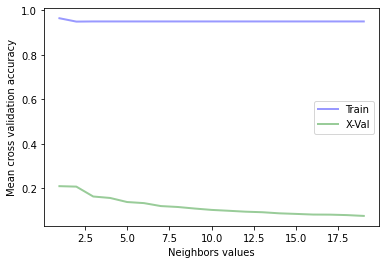

In [52]:
ks = np.arange(1,20)
parameters = {
    'n_neighbors': ks,
    'weights': ['distance'],
    'p': [2]
}
kfold = 5
scoring = 'recall'
knn = KNeighborsClassifier(n_jobs=-1)

grid = best_params(train_all, train_target, knn, parameters, scoring, kfold)
# Plot the error values on the training and cross-validation 
# splits across the specified values of the main parameter to test on.
plot_params(ks, 'Neighbors', grid.cv_results_['mean_train_score'], grid.cv_results_['mean_test_score'])


The elbow is at roughly 2 neighbors.  Let's evaluate our classifier's accuracy on its 2019-2020 popularity predictions based on audio features:

In [53]:
knn = KNeighborsClassifier(n_neighbors=2, weights='distance', p=2, n_jobs=-1).fit(train_all, train_target)
knnpreds_test = knn.predict(test_all)
print(classification_report(test_target, knnpreds_test))

              precision    recall  f1-score   support

           0       0.73      0.71      0.72      1739
           1       0.39      0.41      0.40       770

    accuracy                           0.62      2509
   macro avg       0.56      0.56      0.56      2509
weighted avg       0.63      0.62      0.62      2509



Though our f1-score is worse than the f1-score of our decision tree, our recall for predicted popularity is much higher!


### Training on tracks per genres for genre prediction
#### scoring = 'accuracy'.  GridSearchCB can't score on 'recall' because genre prediction is multiclass.

Next, let's see how well kNN can predict a track's genre.  Again, we'll start with a grid search to find the best number of neighbors to predict on.

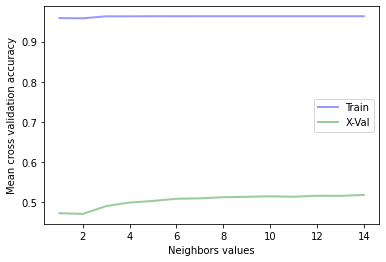

In [54]:
ks = np.arange(1,15)
parameters = {
    'n_neighbors': ks,
    'weights': ['distance'],
    'p': [2]
}
kfold = 5
scoring = 'accuracy'
knn = KNeighborsClassifier(n_jobs=-1)

grid = best_params(train_all_genres, train_target_genres, knn, parameters, scoring, kfold)
plot_params(ks, 'Neighbors', grid.cv_results_['mean_train_score'], grid.cv_results_['mean_test_score'])


In [55]:
# Train on best k neighbors selected
knn = KNeighborsClassifier(n_neighbors=6, weights='distance', p=2, n_jobs=-1).fit(train_all_genres, train_target_genres)
knnpred_test = knn.predict(test_all_genres)
print(classification_report(test_target_genres, knnpred_test))

              precision    recall  f1-score   support

     country       0.64      0.61      0.62       518
        jazz       0.78      0.82      0.80       453
       latin       0.52      0.47      0.49       513
         pop       0.37      0.24      0.29       450
         r&b       0.46      0.63      0.53       575

    accuracy                           0.56      2509
   macro avg       0.55      0.55      0.55      2509
weighted avg       0.55      0.56      0.55      2509



## PCA
### Training on tracks across all genres for popularity

Let's see if our accuracy scores improve by implementing feature selection using the Prinicipal Component Analysis.


In [56]:
def PCATransform(data):
    pca = PCA()
    pca.fit(data)

    toKeep = 0
    totalVar = 0
    # Find PC's that contribute at least 95% data variance
    for var in pca.explained_variance_ratio_:
        if totalVar < .95:
            totalVar += var
            toKeep += 1

    print("Top {} components capture {:.2f}% of the data".format(toKeep,totalVar*100))
    
    # Transform data and select only 'toKeep' PC's, convert back to pandas dataframe
    outData = PCA(n_components = toKeep).fit_transform(data)
    outData = pd.DataFrame(data=outData)
    print("{} -> {}".format(data.shape,outData.shape))
    
    return outData

Since PCA was not designed for categorical variables, we will only perform PCA on our continuous features.

In [57]:
numerical_train_data = train_all.drop(['year', 'duration_ms', 'key_0', 'key_1', 'key_2', 'key_3', 'key_4', 'key_5', 'key_6', 'key_7', 'key_8', 'key_9', 'key_10', 'key_11', 'explicit_0', 'explicit_1', 'mode_0', 'mode_1', 'time_signature_1', 'time_signature_3', 'time_signature_4', 'time_signature_5'], axis=1)
numerical_test_data = test_all.drop(['year', 'duration_ms', 'key_0', 'key_1', 'key_2', 'key_3', 'key_4', 'key_5', 'key_6', 'key_7', 'key_8', 'key_9', 'key_10', 'key_11', 'explicit_0', 'explicit_1', 'mode_0', 'mode_1', 'time_signature_1', 'time_signature_3', 'time_signature_4', 'time_signature_5'], axis=1)

# Transform continuous dataset to PCA to predict on 'popular'
popular_train_pca = PCATransform(numerical_train_data)
popular_test_pca = PCATransform(numerical_test_data)

popular_train_pca.head(3)


Top 7 components capture 97.19% of the data
(20618, 9) -> (20618, 7)
Top 7 components capture 97.35% of the data
(2509, 9) -> (2509, 7)


0         1         2         3         4         5         6
0  0.263867  0.136441 -0.322244  0.221853 -0.073820  0.068099 -0.040516
1 -0.209278 -0.261916  0.149300  0.015678  0.029269  0.064241  0.143470
2 -0.168029  0.285831 -0.291347 -0.042942 -0.140193 -0.031641  0.052888

#### scoring = 'recall'

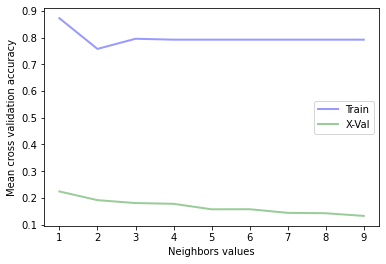

In [58]:
ks = np.arange(1,10)
parameters = {
    'n_neighbors': ks,
    'weights': ['distance'],
    'p': [2]
}
kfold = 5
scoring = 'recall'
knn = KNeighborsClassifier(n_jobs=-1)

grid = best_params(popular_train_pca, train_target, knn, parameters, scoring, kfold)
plot_params(ks, 'Neighbors', grid.cv_results_['mean_train_score'], grid.cv_results_['mean_test_score'])


Let's investigate the best recall score on predicting popularity on the top 3 k neighbors (based on the cross validation scores above).

In [59]:
knn = KNeighborsClassifier(n_neighbors=1, weights='distance', p=2, n_jobs=-1).fit(popular_train_pca, train_target)
knnpred_test = knn.predict(popular_test_pca)
print(classification_report(test_target, knnpred_test))

knn = KNeighborsClassifier(n_neighbors=2, weights='distance', p=2, n_jobs=-1).fit(popular_train_pca, train_target)
knnpred_test = knn.predict(popular_test_pca)
print(classification_report(test_target, knnpred_test))

knn = KNeighborsClassifier(n_neighbors=3, weights='distance', p=2, n_jobs=-1).fit(popular_train_pca, train_target)
knnpred_test = knn.predict(popular_test_pca)
print(classification_report(test_target, knnpred_test))


              precision    recall  f1-score   support

           0       0.71      0.82      0.76      1739
           1       0.39      0.26      0.31       770

    accuracy                           0.65      2509
   macro avg       0.55      0.54      0.54      2509
weighted avg       0.61      0.65      0.62      2509

              precision    recall  f1-score   support

           0       0.71      0.84      0.77      1739
           1       0.37      0.21      0.27       770

    accuracy                           0.65      2509
   macro avg       0.54      0.52      0.52      2509
weighted avg       0.60      0.65      0.61      2509

              precision    recall  f1-score   support

           0       0.72      0.86      0.78      1739
           1       0.43      0.23      0.30       770

    accuracy                           0.67      2509
   macro avg       0.57      0.55      0.54      2509
weighted avg       0.63      0.67      0.63      2509



### Training on tracks for genre prediction

In [60]:
numerical_train_genres = train_all_genres.drop(['key_0', 'key_1', 'key_2', 'key_3', 'key_4', 'key_5', 'key_6', 'key_7', 'key_8', 'key_9', 'key_10', 'key_11', 'explicit_0', 'explicit_1', 'mode_0', 'mode_1', 'time_signature_1', 'time_signature_3', 'time_signature_4', 'time_signature_5'], axis=1)
numerical_test_genres = test_all_genres.drop(['key_0', 'key_1', 'key_2', 'key_3', 'key_4', 'key_5', 'key_6', 'key_7', 'key_8', 'key_9', 'key_10', 'key_11', 'explicit_0', 'explicit_1', 'mode_0', 'mode_1', 'time_signature_1', 'time_signature_3', 'time_signature_4', 'time_signature_5'], axis=1)
numerical_train_genres.head(3)

acousticness  danceability  energy  duration_ms  instrumentalness  valence  \
0        0.6770         0.566   0.468     0.094330          0.000025    0.718   
1        0.0317         0.709   0.744     0.166493          0.000000    0.314   
2        0.3920         0.787   0.732     0.143168          0.000003    0.897   

      tempo  liveness  loudness  speechiness  
0  0.627491    0.2590  0.769913       0.1160  
1  0.536371    0.2950  0.893293       0.0584  
2  0.536281    0.0323  0.895822       0.0310

In [61]:
# Transform dataset to PCA to predict on 'genre'
genres_train_pca = PCATransform(numerical_train_genres)
print(genres_train_pca.shape)
display(genres_train_pca.head(3))

genres_test_pca = PCATransform(numerical_test_genres)


Top 7 components capture 96.66% of the data
(20618, 10) -> (20618, 7)
(20618, 7)


0         1         2         3         4         5         6
0  0.263166  0.138071 -0.323190  0.221715 -0.074260  0.067968 -0.040598
1 -0.208694 -0.262883  0.149751  0.015848  0.029570  0.064373  0.143542
2 -0.168030  0.286683 -0.289521 -0.042635 -0.139387 -0.031403  0.053004

Top 7 components capture 97.04% of the data
(2509, 10) -> (2509, 7)


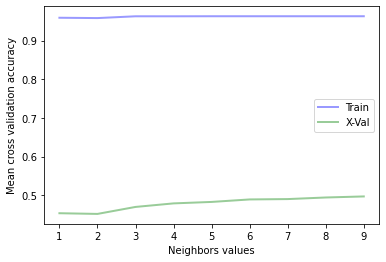

In [62]:
ks = np.arange(1,10)
parameters = {
    'n_neighbors': ks
}
kfold = 5
scoring = 'accuracy'
knn = KNeighborsClassifier(n_jobs=-1, weights='distance')

grid = best_params(genres_train_pca, train_target_genres, knn, parameters, scoring, kfold)
plot_params(ks, 'Neighbors', grid.cv_results_['mean_train_score'], grid.cv_results_['mean_test_score'])


In [63]:
knn = KNeighborsClassifier(n_neighbors=3, weights='distance', p=2, n_jobs=-1).fit(genres_train_pca, train_target_genres)
knn_pred_test = knn.predict(genres_test_pca)
print(classification_report(test_target_genres, knn_pred_test))

knn = KNeighborsClassifier(n_neighbors=4, weights='distance', p=2, n_jobs=-1).fit(genres_train_pca, train_target_genres)
knn_pred_test = knn.predict(genres_test_pca)
print(classification_report(test_target_genres, knn_pred_test))

knn = KNeighborsClassifier(n_neighbors=5, weights='distance', p=2, n_jobs=-1).fit(genres_train_pca, train_target_genres)
knn_pred_test = knn.predict(genres_test_pca)
print(classification_report(test_target_genres, knn_pred_test))

knn = KNeighborsClassifier(n_neighbors=9, weights='distance', p=2, n_jobs=-1).fit(genres_train_pca, train_target_genres)
knn_pred_test = knn.predict(genres_test_pca)
print(classification_report(test_target_genres, knn_pred_test))


              precision    recall  f1-score   support

     country       0.35      0.34      0.35       518
        jazz       0.60      0.78      0.68       453
       latin       0.39      0.38      0.39       513
         pop       0.25      0.22      0.24       450
         r&b       0.35      0.33      0.34       575

    accuracy                           0.40      2509
   macro avg       0.39      0.41      0.40      2509
weighted avg       0.39      0.40      0.39      2509

              precision    recall  f1-score   support

     country       0.37      0.35      0.36       518
        jazz       0.65      0.78      0.71       453
       latin       0.42      0.42      0.42       513
         pop       0.24      0.21      0.22       450
         r&b       0.35      0.34      0.35       575

    accuracy                           0.42      2509
   macro avg       0.40      0.42      0.41      2509
weighted avg       0.40      0.42      0.41      2509

              precisio

When testing on all features for popularity prediction, our best scores were 
    
              precision    recall  f1-score   support

           0       0.73      0.71      0.72      1739
           1       0.39      0.41      0.40       770

    accuracy                           0.62      2509


When testing on all features for genre prediction, our best scores were 

              precision    recall  f1-score   support

     country       0.64      0.61      0.62       518
        jazz       0.78      0.82      0.80       453
       latin       0.52      0.47      0.49       513
         pop       0.37      0.24      0.29       450
         r&b       0.46      0.63      0.53       575

    accuracy                           0.56      2509

When testing on all PCA transformed feature set for popularity prediction, our best scores were 
    
              precision    recall  f1-score   support

           0       0.71      0.82      0.76      1739
           1       0.39      0.26      0.31       770

    accuracy                           0.65      2509

When testing on all PCA transformed feature set for genre prediction, our best scores were 

              precision    recall  f1-score   support

     country       0.37      0.39      0.38       518
        jazz       0.71      0.81      0.76       453
       latin       0.46      0.44      0.45       513
         pop       0.26      0.21      0.23       450
         r&b       0.35      0.36      0.35       575

    accuracy                           0.44      2509


In conclusion, selecting features based on PCA mildly improved our accuracy scores.  However, the recall scores on predicting popularity & genre decreased on the PCA transformed dataset, where it matters most.

### Backward Selection
We had planned to use sklearn's SequentialFeatureSelector method for Forward & Backward feature selection, however, we were unable to import it because it was introduced in scikit-learn version 0.24.  Anaconda's environment is running on version 0.23.3, without an option to update.

In [ ]:
# from sklearn.feature_selection import SequentialFeatureSelector
# knn = KNeighborsClassifier(n_neighbors=5)
# sfs = feature_selection.SequentialFeatureSelector(knn, n_features_to_select=5)
# sfs.fit(train_all, train_target)
# sfs.get_params()

# ---------------------------------------------------------------------------
# ImportError                               Traceback (most recent call last)
# <ipython-input-57-11d76c26e7d1> in <module>
# ----> 1 from sklearn.feature_selection import SequentialFeatureSelector
#       2 knn = KNeighborsClassifier(n_neighbors=5)
#       3 sfs = feature_selection.SequentialFeatureSelector(knn, n_features_to_select=5)
#       4 sfs.fit(train_all, train_target)
#       5 sfs.get_params()

# ImportError: cannot import name 'SequentialFeatureSelector' from 'sklearn.feature_selection' (/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/__init__.py)



# Cluster Analysis

## DBSCAN

So far, our models have failed to return a satisfactory accuracy/recall score to predict audio features that would indicate a 'popular' track.  Instead, we may find better luck in detecting a genre based on audio features.  We will use the density based clustering method (DBSCAN) to predict a track's genre.  DBSCAN is useful in detecting outliers as well, which will be interesting to visualize if our results are meaningful.

### Fit on all features

We remove the 'year' feature since it should be irrelavant to genre prediction.  
Our classification methods proved 'duration' to be more useful than we had initially imagined, in particular with predicting popularity within the pop, latin, & jazz genres.  This makes sense for the Jazz genre, but we're not sure why that would also apply to the Latin & Pop genres.  Thus, we shall keep this feature in the data to see if it'll add any more insights to our findings.


In [64]:
# We want all the raw_data, except for the popular, chartrank, & year columns.
X = train_matrix.drop(columns=['year'])

# Our target will be the genre feature this time
labels_true = X.pop('genre')

X = X.values
labels_true = labels_true.values


Code source below provided by scikit-learn's DBSCAN demo: https://scikit-learn.org/stable/auto_examples/cluster/plot_dbscan.html#sphx-glr-auto-examples-cluster-plot-dbscan-py 

In [65]:
def d_cluster_analysis(X, labels_true, epsilons, minSamples):
    est_clusters = []
    h_scores = [] # Homogeneity 
    c_scores = [] # Completeness
    v_scores = [] # Homogeniety + Completeness score

    for e in epsilons:
        for m in minSamples:
            # Compute DBSCAN
            dbs = DBSCAN(eps=e, min_samples=m, n_jobs=-1).fit(X)
            core_samples_mask = np.zeros_like(dbs.labels_, dtype=bool)
            core_samples_mask[dbs.core_sample_indices_] = True
            labels = dbs.labels_
            print(f'DBSCAN with epsilon value of {e}:')

            # Number of clusters in labels, ignoring noise if present.
            n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
            n_noise_ = list(labels).count(-1)

            est_clusters.append(n_clusters_)
            print('Estimated number of clusters: %d' % n_clusters_)
            print('Estimated number of noise points: %d' % n_noise_)

            # Accuracy Scores
            hscore = metrics.homogeneity_score(labels_true, labels)
            h_scores.append(hscore)
            print("Homogeneity: %0.3f" % hscore)        
            cscore = metrics.completeness_score(labels_true, labels)
            c_scores.append(cscore)
            print("Completeness: %0.3f" % cscore)
            vscore = metrics.v_measure_score(labels_true, labels)
            v_scores.append(vscore)
            print("V-measure (Combined Homogeneity & Completeness scores): %0.3f" % vscore)
            print("Adjusted Rand Index: %0.3f"
                  % metrics.adjusted_rand_score(labels_true, labels))
            print("Adjusted Mutual Information: %0.3f"
                  % metrics.adjusted_mutual_info_score(labels_true, labels))
            print("Silhouette Coefficient: %0.3f"
                  % metrics.silhouette_score(X, labels))

            # Black removed and is used for noise instead.
            unique_labels = set(labels)
            colors = [plt.cm.Spectral(each)
                      for each in np.linspace(0, 1, len(unique_labels))]
            for k, col in zip(unique_labels, colors):
                if k == -1:
                    # Black used for noise.
                    col = [0, 0, 0, 1]

                class_member_mask = (labels == k)

                xy = X[class_member_mask & core_samples_mask]
                plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col), markeredgecolor='k', markersize=14)

                xy = X[class_member_mask & ~core_samples_mask]
                plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
                         markeredgecolor='k', markersize=6)

            plt.title('Estimated number of clusters: %d' % n_clusters_)
            plt.show()
            print()
    
    return est_clusters, h_scores, c_scores, v_scores


In [66]:
def plot_clustering_params(param_values, param_name, h_scores, c_scores, v_scores):
    plt.plot(param_values, h_scores, label='Homogeneity Score', alpha=0.4, lw=2, c='b')
    plt.plot(param_values, c_scores, label='Completeness Score', alpha=0.4, lw=2, c='g')
    plt.plot(param_values, v_scores, label='V-Measure', alpha=0.4, lw=2, c='r')
    plt.legend(loc=7)
    plt.xlabel(param_name + " values")
    plt.ylabel("Accuracy Scores")

### Using our training data 
#### min_samples = 10

DBSCAN with epsilon value of 0.2:
Estimated number of clusters: 54
Estimated number of noise points: 14118
Homogeneity: 0.061
Completeness: 0.062
V-measure (Combined Homogeneity & Completeness scores): 0.062
Adjusted Rand Index: 0.022
Adjusted Mutual Information: 0.058
Silhouette Coefficient: -0.315


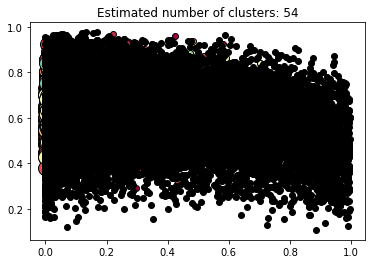


DBSCAN with epsilon value of 0.3:
Estimated number of clusters: 71
Estimated number of noise points: 5793
Homogeneity: 0.103
Completeness: 0.054
V-measure (Combined Homogeneity & Completeness scores): 0.071
Adjusted Rand Index: 0.037
Adjusted Mutual Information: 0.068
Silhouette Coefficient: 0.170


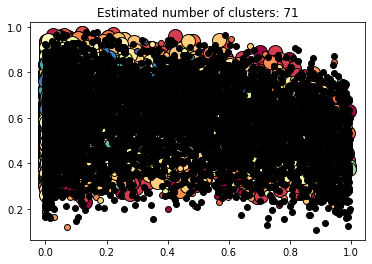


DBSCAN with epsilon value of 0.4:
Estimated number of clusters: 76
Estimated number of noise points: 2339
Homogeneity: 0.103
Completeness: 0.047
V-measure (Combined Homogeneity & Completeness scores): 0.064
Adjusted Rand Index: 0.019
Adjusted Mutual Information: 0.062
Silhouette Coefficient: 0.389


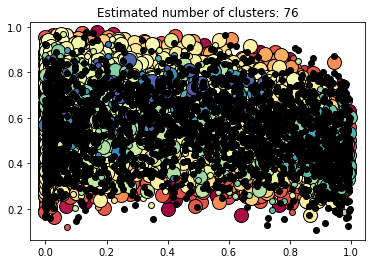


DBSCAN with epsilon value of 0.5:
Estimated number of clusters: 69
Estimated number of noise points: 1110
Homogeneity: 0.092
Completeness: 0.041
V-measure (Combined Homogeneity & Completeness scores): 0.057
Adjusted Rand Index: 0.012
Adjusted Mutual Information: 0.054
Silhouette Coefficient: 0.485


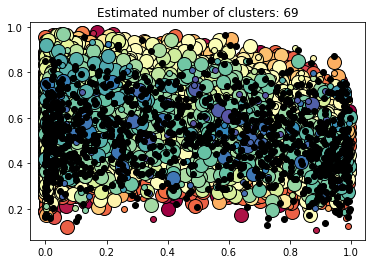


DBSCAN with epsilon value of 0.6:
Estimated number of clusters: 70
Estimated number of noise points: 708
Homogeneity: 0.087
Completeness: 0.039
V-measure (Combined Homogeneity & Completeness scores): 0.053
Adjusted Rand Index: 0.011
Adjusted Mutual Information: 0.051
Silhouette Coefficient: 0.513


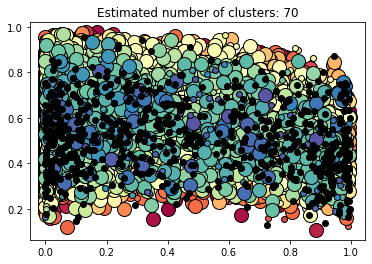


DBSCAN with epsilon value of 0.7:
Estimated number of clusters: 72
Estimated number of noise points: 555
Homogeneity: 0.087
Completeness: 0.038
V-measure (Combined Homogeneity & Completeness scores): 0.053
Adjusted Rand Index: 0.010
Adjusted Mutual Information: 0.050
Silhouette Coefficient: 0.519


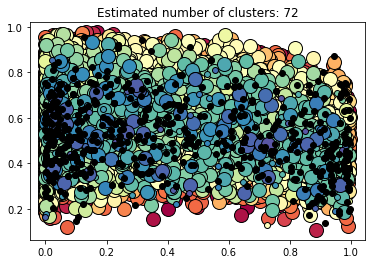


DBSCAN with epsilon value of 0.8:
Estimated number of clusters: 72
Estimated number of noise points: 492
Homogeneity: 0.086
Completeness: 0.038
V-measure (Combined Homogeneity & Completeness scores): 0.053
Adjusted Rand Index: 0.010
Adjusted Mutual Information: 0.050
Silhouette Coefficient: 0.522


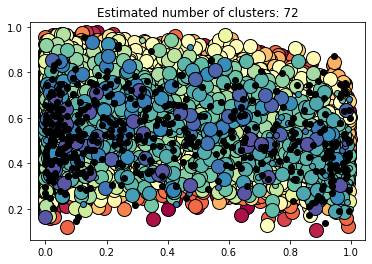


DBSCAN with epsilon value of 0.9:
Estimated number of clusters: 74
Estimated number of noise points: 430
Homogeneity: 0.087
Completeness: 0.038
V-measure (Combined Homogeneity & Completeness scores): 0.053
Adjusted Rand Index: 0.010
Adjusted Mutual Information: 0.050
Silhouette Coefficient: 0.524


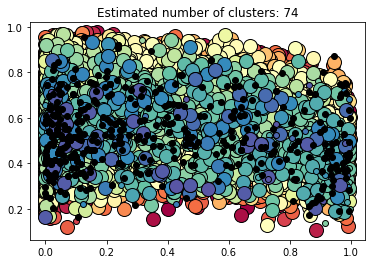

In [67]:
eps = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
est_clusters, h_scores, c_scores, v_scores = d_cluster_analysis(X, labels_true, eps, [10])

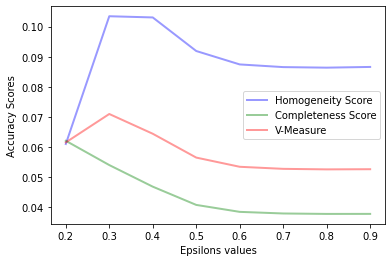

In [68]:
plot_clustering_params(eps, 'Epsilons', h_scores, c_scores, v_scores)

Text(0, 0.5, 'Estimated Cluster size')

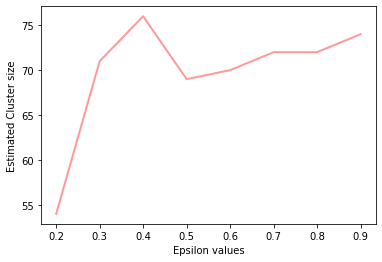

In [69]:
plt.plot(eps, est_clusters, alpha=0.4, lw=2, c='r')
plt.xlabel("Epsilon values")
plt.ylabel("Estimated Cluster size")

DBSCAN with epsilon value of 0.1 returned 0 clusters, with all points considered "noise points".

DBSCAN with epsilon value of 0.2 returned 54 clusters, with 14,118 considered "noise points".

DBSCAN with epsilon value of 0.3 returned 71 clusters, with 5,793 considered "noise points".

DBSCAN with epsilon value of 0.4 returned 76 clusters, with 2,339 considered "noise points".

DBSCAN with epsilon value of 0.5 returned 69 clusters, with 1,110 considered "noise points".

DBSCAN with epsilon value of 0.6 returned 70 clusters, with 708 considered "noise points".

DBSCAN with epsilon value of 0.7 returned 72 clusters, with 555 considered "noise points".

DBSCAN with epsilon value of 0.8 returned 72 clusters, with 492 considered "noise points".

DBSCAN with epsilon value of 0.9 returned 74 clusters, with 430 considered "noise points".

A small min_sample of 10 returned an average cluster of 62. The range of cluster size for that min sample across an epsilon value between 0.0 & 1.0 was 54 to 74.


#### min samples = 50
We know we have at least 3,000 track samples per genre, so let's increase our min_sample to 50. We chose 50 because at 100 we were getting errors.

DBSCAN with epsilon value of 0.2:
Estimated number of clusters: 7
Estimated number of noise points: 19982
Homogeneity: 0.007
Completeness: 0.062
V-measure (Combined Homogeneity & Completeness scores): 0.013
Adjusted Rand Index: 0.000
Adjusted Mutual Information: 0.013
Silhouette Coefficient: -0.253


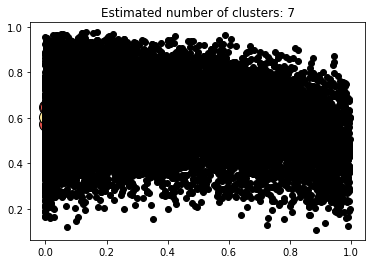


DBSCAN with epsilon value of 0.3:
Estimated number of clusters: 21
Estimated number of noise points: 11388
Homogeneity: 0.063
Completeness: 0.052
V-measure (Combined Homogeneity & Completeness scores): 0.057
Adjusted Rand Index: 0.034
Adjusted Mutual Information: 0.056
Silhouette Coefficient: 0.030


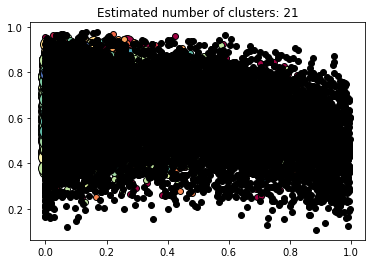


DBSCAN with epsilon value of 0.4:
Estimated number of clusters: 34
Estimated number of noise points: 6070
Homogeneity: 0.084
Completeness: 0.047
V-measure (Combined Homogeneity & Completeness scores): 0.060
Adjusted Rand Index: 0.040
Adjusted Mutual Information: 0.059
Silhouette Coefficient: 0.286


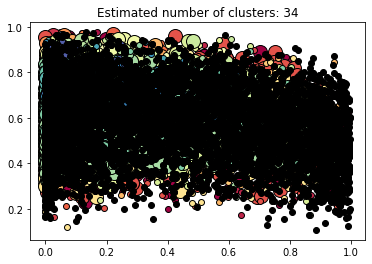


DBSCAN with epsilon value of 0.5:
Estimated number of clusters: 42
Estimated number of noise points: 3475
Homogeneity: 0.087
Completeness: 0.043
V-measure (Combined Homogeneity & Completeness scores): 0.058
Adjusted Rand Index: 0.027
Adjusted Mutual Information: 0.056
Silhouette Coefficient: 0.409


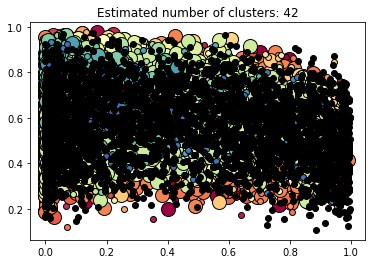


DBSCAN with epsilon value of 0.6:
Estimated number of clusters: 46
Estimated number of noise points: 2077
Homogeneity: 0.083
Completeness: 0.039
V-measure (Combined Homogeneity & Completeness scores): 0.053
Adjusted Rand Index: 0.015
Adjusted Mutual Information: 0.051
Silhouette Coefficient: 0.465


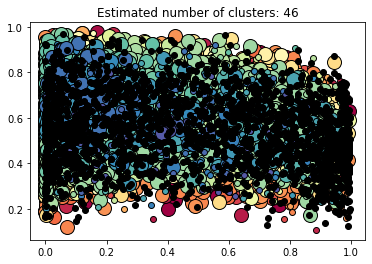


DBSCAN with epsilon value of 0.7:
Estimated number of clusters: 51
Estimated number of noise points: 1327
Homogeneity: 0.081
Completeness: 0.037
V-measure (Combined Homogeneity & Completeness scores): 0.051
Adjusted Rand Index: 0.011
Adjusted Mutual Information: 0.049
Silhouette Coefficient: 0.491


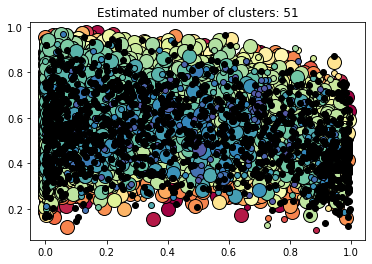


DBSCAN with epsilon value of 0.8:
Estimated number of clusters: 52
Estimated number of noise points: 1100
Homogeneity: 0.082
Completeness: 0.037
V-measure (Combined Homogeneity & Completeness scores): 0.051
Adjusted Rand Index: 0.011
Adjusted Mutual Information: 0.049
Silhouette Coefficient: 0.499


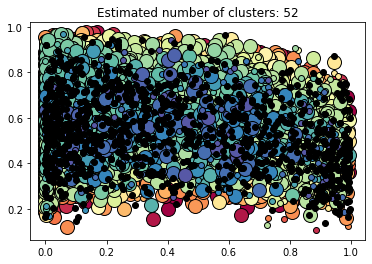


DBSCAN with epsilon value of 0.9:
Estimated number of clusters: 53
Estimated number of noise points: 1013
Homogeneity: 0.082
Completeness: 0.037
V-measure (Combined Homogeneity & Completeness scores): 0.051
Adjusted Rand Index: 0.011
Adjusted Mutual Information: 0.049
Silhouette Coefficient: 0.503


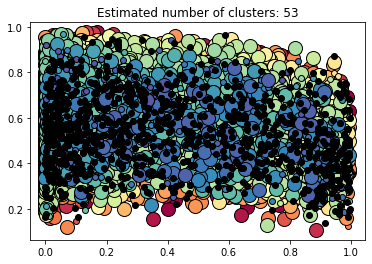


DBSCAN with epsilon value of 1.0:
Estimated number of clusters: 53
Estimated number of noise points: 981
Homogeneity: 0.082
Completeness: 0.037
V-measure (Combined Homogeneity & Completeness scores): 0.051
Adjusted Rand Index: 0.011
Adjusted Mutual Information: 0.049
Silhouette Coefficient: 0.504


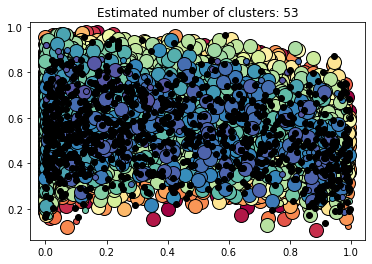

In [70]:
eps = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
est_clusters, h_scores, c_scores, v_scores = d_cluster_analysis(X, labels_true, eps, [50])    


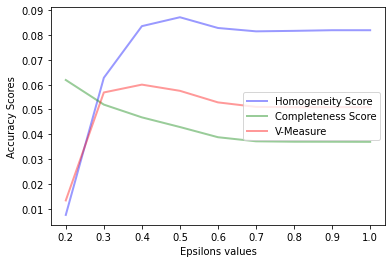

In [71]:
plot_clustering_params(eps, 'Epsilons', h_scores, c_scores, v_scores)


As we see in the plot, our accuracy scores did not improve.  The last epsilon value of 2.0 with the accuracy score of 100% was because it clustered all points into 1 cluster, making that score invalid. Epsilons > 2.0 were thus not calculated.


Text(0, 0.5, 'Estimated Cluster size')

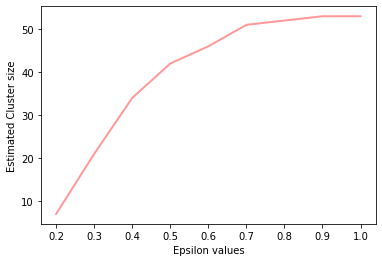

In [72]:
eps = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

plt.plot(eps, est_clusters, alpha=0.4, lw=2, c='r')
plt.xlabel("Epsilon values")
plt.ylabel("Estimated Cluster size")

A lower epsilon value returned cluster sizes closer to our target cluster size of 5, however, it considered all other points as noise.  This leads us to believe we may have too much data.  

**Tracks per genre in train sample:**
- 4221
- 3835
- 4196
- 3708
- 4658

### Using our test data to simulate a smaller sample size 
Next, we will test clustering on a smaller sample size - our test data.  Our theory is that by reducing our sample size, we might get better completeness and homogeneity scores.

**Tracks per genre in test sample:**
- 518
- 453
- 513
- 450
- 575

#### min_sample = 50

In [73]:
# All the raw test data (tracks in years >= 2019) except for the popular, chartrank, & year columns.
X_test = test_matrix.drop(columns=['year'])
test_labels_true = X_test.pop('genre')
X_test = X_test.values
test_labels_true = test_labels_true.values


DBSCAN with epsilon value of 0.5:
Estimated number of clusters: 7
Estimated number of noise points: 1979
Homogeneity: 0.047
Completeness: 0.082
V-measure (Combined Homogeneity & Completeness scores): 0.060
Adjusted Rand Index: 0.017
Adjusted Mutual Information: 0.056
Silhouette Coefficient: -0.016


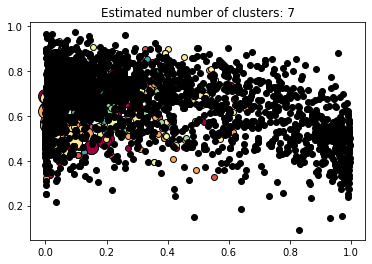


DBSCAN with epsilon value of 0.6:
Estimated number of clusters: 11
Estimated number of noise points: 1647
Homogeneity: 0.070
Completeness: 0.077
V-measure (Combined Homogeneity & Completeness scores): 0.073
Adjusted Rand Index: 0.030
Adjusted Mutual Information: 0.068
Silhouette Coefficient: 0.047


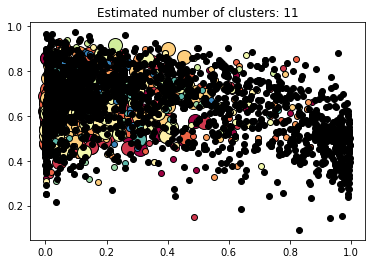


DBSCAN with epsilon value of 0.7:
Estimated number of clusters: 13
Estimated number of noise points: 1449
Homogeneity: 0.081
Completeness: 0.075
V-measure (Combined Homogeneity & Completeness scores): 0.078
Adjusted Rand Index: 0.038
Adjusted Mutual Information: 0.072
Silhouette Coefficient: 0.115


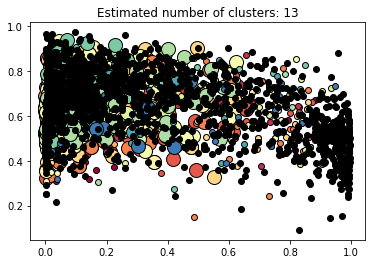


DBSCAN with epsilon value of 0.8:
Estimated number of clusters: 15
Estimated number of noise points: 1294
Homogeneity: 0.085
Completeness: 0.069
V-measure (Combined Homogeneity & Completeness scores): 0.076
Adjusted Rand Index: 0.042
Adjusted Mutual Information: 0.069
Silhouette Coefficient: 0.153


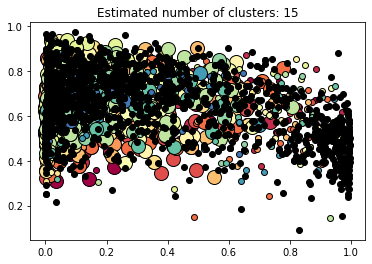


DBSCAN with epsilon value of 0.9:
Estimated number of clusters: 15
Estimated number of noise points: 1249
Homogeneity: 0.079
Completeness: 0.062
V-measure (Combined Homogeneity & Completeness scores): 0.070
Adjusted Rand Index: 0.040
Adjusted Mutual Information: 0.063
Silhouette Coefficient: 0.164


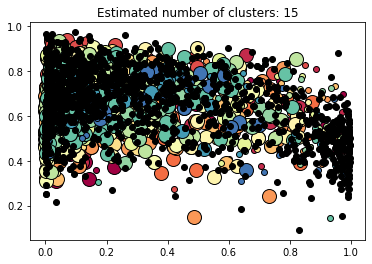


DBSCAN with epsilon value of 1.0:
Estimated number of clusters: 17
Estimated number of noise points: 1092
Homogeneity: 0.082
Completeness: 0.058
V-measure (Combined Homogeneity & Completeness scores): 0.068
Adjusted Rand Index: 0.040
Adjusted Mutual Information: 0.061
Silhouette Coefficient: 0.199


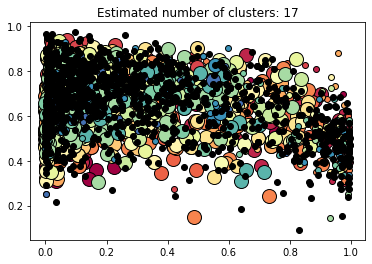

In [74]:
eps = [0.5, 0.6, 0.7, 0.8, 0.9, 1.0] # Error: 0 clusters at eps < 0.5 & eps >=2.0 & 
est_clusters, h_scores, c_scores, v_scores = d_cluster_analysis(X_test, test_labels_true, eps, [50])


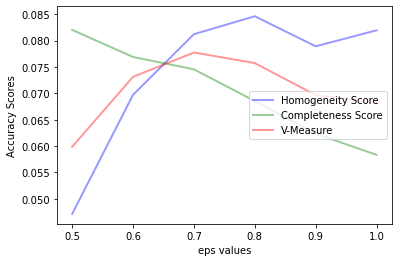

In [75]:
param_name = 'eps'
plot_clustering_params(eps, param_name, h_scores, c_scores, v_scores)


Text(0, 0.5, 'Estimated Cluster size')

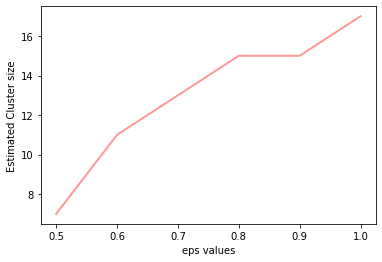

In [76]:
plt.plot(eps, est_clusters, alpha=0.4, lw=2, c='r')
plt.xlabel(param_name + " values")
plt.ylabel("Estimated Cluster size")

An epsilon value of 0.7 gave us the best v-measure at 0.078 (combination of homogeneity & completeness).  However, that is still a poor score and estimated 13 clusters, whereas an epsilon of 0.5 gave us the closes number of clusters to the true data at size 7.

#### min_samples=100

DBSCAN with epsilon value of 0.7:
Estimated number of clusters: 2
Estimated number of noise points: 2286
Homogeneity: 0.010
Completeness: 0.046
V-measure (Combined Homogeneity & Completeness scores): 0.017
Adjusted Rand Index: 0.002
Adjusted Mutual Information: 0.015
Silhouette Coefficient: -0.034


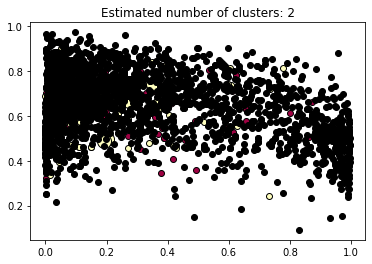


DBSCAN with epsilon value of 0.8:
Estimated number of clusters: 2
Estimated number of noise points: 2264
Homogeneity: 0.008
Completeness: 0.032
V-measure (Combined Homogeneity & Completeness scores): 0.013
Adjusted Rand Index: 0.002
Adjusted Mutual Information: 0.011
Silhouette Coefficient: -0.026


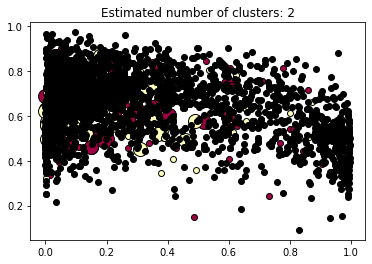


DBSCAN with epsilon value of 0.9:
Estimated number of clusters: 2
Estimated number of noise points: 2252
Homogeneity: 0.007
Completeness: 0.027
V-measure (Combined Homogeneity & Completeness scores): 0.011
Adjusted Rand Index: 0.003
Adjusted Mutual Information: 0.009
Silhouette Coefficient: -0.020


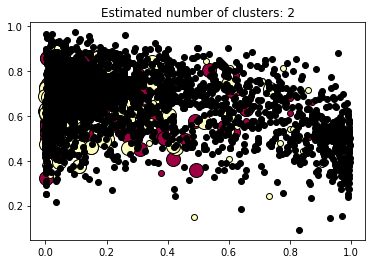


DBSCAN with epsilon value of 1.0:
Estimated number of clusters: 3
Estimated number of noise points: 2130
Homogeneity: 0.011
Completeness: 0.031
V-measure (Combined Homogeneity & Completeness scores): 0.017
Adjusted Rand Index: 0.006
Adjusted Mutual Information: 0.014
Silhouette Coefficient: -0.000


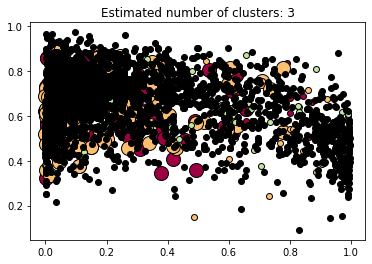


DBSCAN with epsilon value of 1.5:
Estimated number of clusters: 1
Estimated number of noise points: 34
Homogeneity: 0.004
Completeness: 0.084
V-measure (Combined Homogeneity & Completeness scores): 0.007
Adjusted Rand Index: 0.001
Adjusted Mutual Information: 0.006
Silhouette Coefficient: 0.192


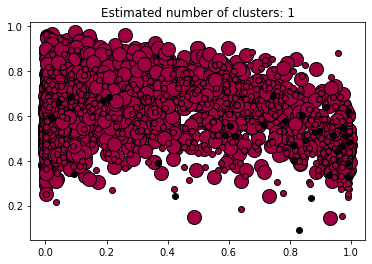

In [77]:
eps = [0.7, 0.8, 0.9, 1.0, 1.5] # Error: 0 clusters at eps < 0.7 & eps >=1.5  
est_clusters, h_scores, c_scores, v_scores = d_cluster_analysis(X_test, test_labels_true, eps, [100])


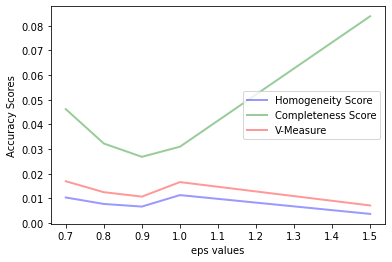

In [78]:
plot_clustering_params(eps, param_name, h_scores, c_scores, v_scores)

Text(0, 0.5, 'Estimated Cluster size')

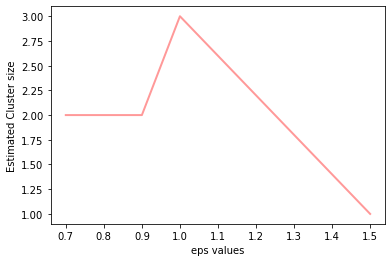

In [79]:
plt.plot(eps, est_clusters, alpha=0.4, lw=2, c='r')
plt.xlabel(param_name + " values")
plt.ylabel("Estimated Cluster size")

Higher min samples gave us better results, but the results were still poor.  Across all tests our accuracy rate was <10%. Cluster sizes were either too low or too high from our goal of 5.  Minimizing our sample size did not make a significant impact on the results.  

### Fit on PCA transformed features
Next, we will test clustering on a smaller feature size.  Our theory is that by reducing our feature size, we might get better completeness and homogeneity scores.


#### min_samples = 10

DBSCAN with epsilon value of 0.1:
Estimated number of clusters: 50
Estimated number of noise points: 13029
Homogeneity: 0.039
Completeness: 0.069
V-measure (Combined Homogeneity & Completeness scores): 0.050
Adjusted Rand Index: 0.022
Adjusted Mutual Information: 0.045
Silhouette Coefficient: -0.503


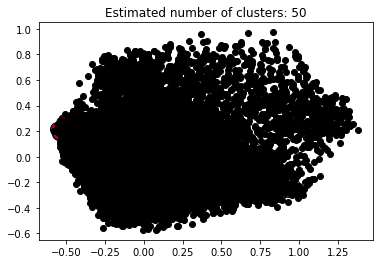


DBSCAN with epsilon value of 0.2:
Estimated number of clusters: 3
Estimated number of noise points: 1585
Homogeneity: 0.022
Completeness: 0.126
V-measure (Combined Homogeneity & Completeness scores): 0.037
Adjusted Rand Index: 0.010
Adjusted Mutual Information: 0.037
Silhouette Coefficient: -0.095


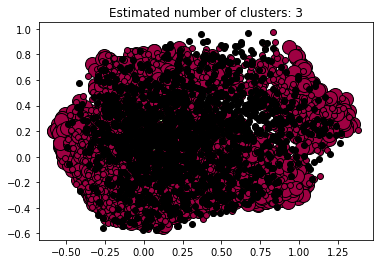


DBSCAN with epsilon value of 0.3:
Estimated number of clusters: 1
Estimated number of noise points: 110
Homogeneity: 0.003
Completeness: 0.144
V-measure (Combined Homogeneity & Completeness scores): 0.006
Adjusted Rand Index: 0.000
Adjusted Mutual Information: 0.006
Silhouette Coefficient: 0.359


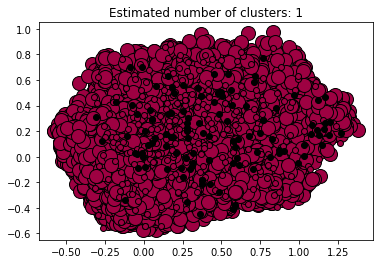


DBSCAN with epsilon value of 0.4:
Estimated number of clusters: 1
Estimated number of noise points: 13
Homogeneity: 0.000
Completeness: 0.070
V-measure (Combined Homogeneity & Completeness scores): 0.000
Adjusted Rand Index: 0.000
Adjusted Mutual Information: 0.000
Silhouette Coefficient: 0.407


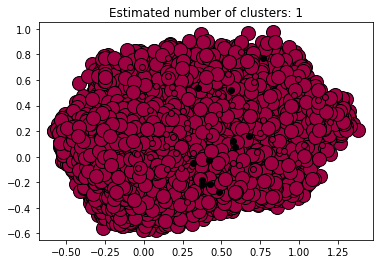


DBSCAN with epsilon value of 0.5:
Estimated number of clusters: 1
Estimated number of noise points: 1
Homogeneity: 0.000
Completeness: 0.154
V-measure (Combined Homogeneity & Completeness scores): 0.000
Adjusted Rand Index: 0.000
Adjusted Mutual Information: 0.000
Silhouette Coefficient: 0.449


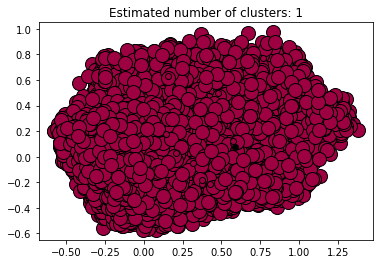

In [80]:
eps = [0.1, 0.2, 0.3, 0.4, 0.5] # Error: 0 clusters at eps >= 0.6
g_train_pca = np.array(genres_train_pca)

est_clusters, h_scores, c_scores, v_scores = d_cluster_analysis(g_train_pca, labels_true, eps, [10]) 


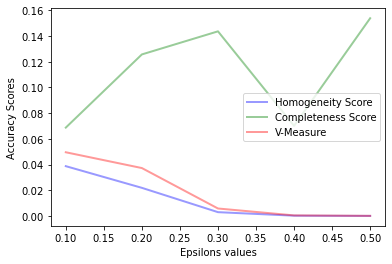

In [81]:
plot_clustering_params(eps, 'Epsilons', h_scores, c_scores, v_scores)


Text(0, 0.5, 'Estimated Cluster size')

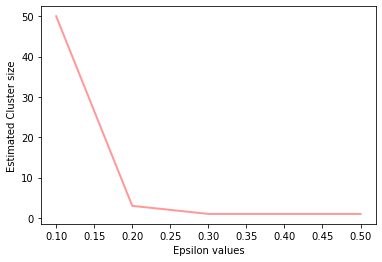

In [82]:
plt.plot(eps, est_clusters, alpha=0.4, lw=2, c='r')
plt.xlabel("Epsilon values")
plt.ylabel("Estimated Cluster size")

#### min_samples = 50

DBSCAN with epsilon value of 0.1:
Estimated number of clusters: 3
Estimated number of noise points: 20299
Homogeneity: 0.003
Completeness: 0.051
V-measure (Combined Homogeneity & Completeness scores): 0.005
Adjusted Rand Index: 0.000
Adjusted Mutual Information: 0.005
Silhouette Coefficient: -0.247


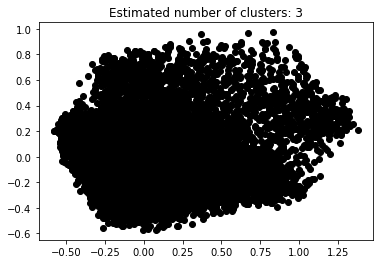


DBSCAN with epsilon value of 0.2:
Estimated number of clusters: 3
Estimated number of noise points: 3633
Homogeneity: 0.065
Completeness: 0.192
V-measure (Combined Homogeneity & Completeness scores): 0.097
Adjusted Rand Index: 0.046
Adjusted Mutual Information: 0.097
Silhouette Coefficient: 0.228


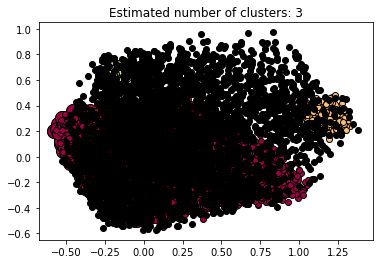


DBSCAN with epsilon value of 0.3:
Estimated number of clusters: 1
Estimated number of noise points: 504
Homogeneity: 0.009
Completeness: 0.125
V-measure (Combined Homogeneity & Completeness scores): 0.017
Adjusted Rand Index: 0.002
Adjusted Mutual Information: 0.017
Silhouette Coefficient: 0.331


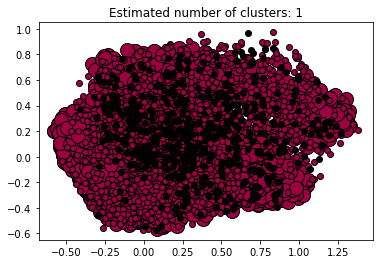


DBSCAN with epsilon value of 0.4:
Estimated number of clusters: 1
Estimated number of noise points: 57
Homogeneity: 0.002
Completeness: 0.131
V-measure (Combined Homogeneity & Completeness scores): 0.003
Adjusted Rand Index: 0.000
Adjusted Mutual Information: 0.003
Silhouette Coefficient: 0.410


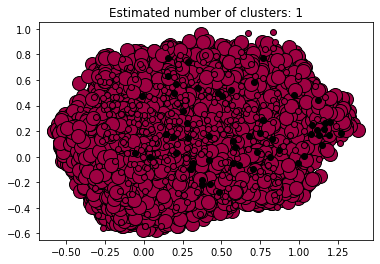


DBSCAN with epsilon value of 0.5:
Estimated number of clusters: 1
Estimated number of noise points: 3
Homogeneity: 0.000
Completeness: 0.171
V-measure (Combined Homogeneity & Completeness scores): 0.000
Adjusted Rand Index: 0.000
Adjusted Mutual Information: 0.000
Silhouette Coefficient: 0.479


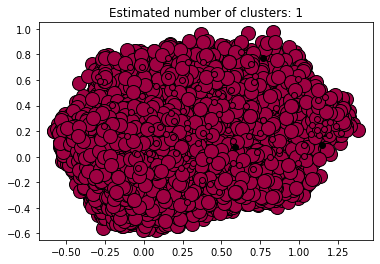


DBSCAN with epsilon value of 0.6:
Estimated number of clusters: 1
Estimated number of noise points: 1
Homogeneity: 0.000
Completeness: 0.154
V-measure (Combined Homogeneity & Completeness scores): 0.000
Adjusted Rand Index: 0.000
Adjusted Mutual Information: 0.000
Silhouette Coefficient: 0.449


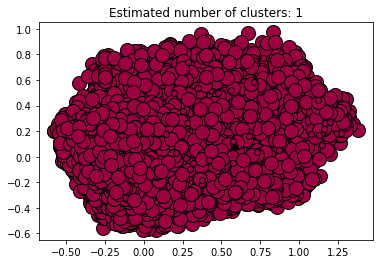

In [83]:
eps = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6] # Error: 0 clusters at eps >= 0.7

est_clusters, h_scores, c_scores, v_scores = d_cluster_analysis(g_train_pca, labels_true, eps, [50])    


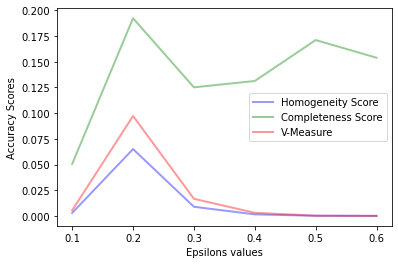

In [84]:
plot_clustering_params(eps, 'Epsilons', h_scores, c_scores, v_scores)


Text(0, 0.5, 'Estimated Cluster size')

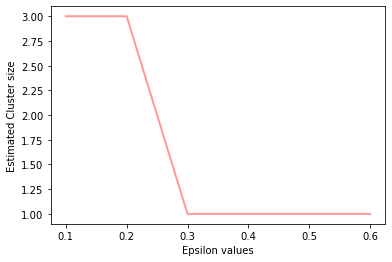

In [85]:
plt.plot(eps, est_clusters, alpha=0.4, lw=2, c='r')
plt.xlabel("Epsilon values")
plt.ylabel("Estimated Cluster size")

Using the PCA transformed dataset with density based clustering did not return significant improvements, but it at least consolidated around the recommended epsilon value of 0.2.

## kMeans
We use kMeans to explore how well kMeans could predict a song's genre based on its features.

### Using all features

In [86]:
X = train_matrix.drop(columns=['year'])
X_labels_true = X.pop('genre')

X = X.values
X_labels_true = X_labels_true.values

In [87]:
kmeans = KMeans(n_clusters=5, random_state=33, n_jobs=-1).fit(X)
clusters = kmeans.predict(X)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:938: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"


In [88]:
X_columns = ['acousticness', 'danceability', 'energy',
       'duration_ms', 'instrumentalness', 'valence', 'tempo', 'liveness',
       'loudness', 'speechiness', 'key_0', 'key_1', 'key_2', 'key_3', 'key_4',
       'key_5', 'key_6', 'key_7', 'key_8', 'key_9', 'key_10', 'key_11',
       'explicit_0', 'explicit_1', 'mode_0', 'mode_1', 'time_signature_1',
       'time_signature_3', 'time_signature_4', 'time_signature_5']
centroids = pd.DataFrame(kmeans.cluster_centers_, columns=X_columns)
centroids

acousticness  danceability    energy  duration_ms  instrumentalness  \
0      0.504409      0.516571  0.462668     0.129211          0.113463   
1      0.291985      0.602712  0.637462     0.130788          0.069941   
2      0.274663      0.643010  0.647505     0.136881          0.142344   
3      0.312843      0.606061  0.620549     0.132344          0.083578   
4      0.187129      0.690910  0.642168     0.134651          0.006424   

    valence     tempo  liveness  loudness  speechiness         key_0  \
0  0.443026  0.499813  0.186671  0.776242     0.066524  1.368876e-01   
1  0.542770  0.465865  0.191064  0.828252     0.061618 -7.910339e-16   
2  0.569852  0.446986  0.190841  0.823732     0.081171  7.539248e-02   
3  0.550268  0.465079  0.202760  0.821343     0.058135  1.000000e+00   
4  0.489783  0.465474  0.195476  0.845368     0.165754  9.726225e-02   

          key_1         key_2         key_3         key_4         key_5  \
0  7.636888e-02  1.023055e-01  5.259366e-02  7.708934e-02  9.365994e-02   
1  1.171850e-01  1.388388e-01  3.619573e-02  7.419595e-02  8.725188e-02   
2  8.652793e-02  5.713764e-02  3.358890e-02  9.510770e-02  1.328952e-01   
3  2.359224e-16  2.359224e-16 -1.804112e-16  5.412337e-16  4.163336e-16   
4  1.772334e-01  7.096542e-02  2.881844e-02  4.178674e-02  6.412104e-02   

          key_6         key_7         key_8         key_9        key_10  \
0  5.331412e-02  1.311239e-01  6.340058e-02  9.221902e-02  7.636888e-02   
1  6.634115e-02  1.568836e-01  9.277147e-02  1.045537e-01  6.368751e-02   
2  8.050383e-02  8.251187e-02  4.289887e-02  1.013143e-01  9.200438e-02   
3  6.106227e-16  4.163336e-16 -3.469447e-16  1.387779e-17 -4.857226e-16   
4  8.357349e-02  8.825648e-02  9.365994e-02  8.357349e-02  6.808357e-02   

         key_11    explicit_0    explicit_1        mode_0        mode_1  \
0  4.466859e-02  9.733429e-01  2.665706e-02  2.096542e-01  7.903458e-01   
1  6.209532e-02  1.000000e+00  1.831868e-15  5.162537e-15  1.000000e+00   
2  1.201168e-01  1.000000e+00 -8.326673e-16  1.000000e+00 -5.329071e-15   
3 -2.081668e-16  1.000000e+00 -7.216450e-16  2.498002e-15  1.000000e+00   
4  1.026657e-01 -1.199041e-14  1.000000e+00  4.499280e-01  5.500720e-01   

   time_signature_1  time_signature_3  time_signature_4  time_signature_5  
0          0.019452      9.524496e-01     -1.332268e-15          0.028098  
1          0.003078     -1.512679e-15      9.926759e-01          0.004246  
2          0.005659      9.714451e-16      9.828405e-01          0.011501  
3          0.005788      3.469447e-16      9.864952e-01          0.007717  
4          0.004683      1.765130e-02      9.528098e-01          0.024856

In [89]:
def cluster_sizes(clusters, data):
    #clusters is an array of cluster labels for each instance in the data
    size = {}
    cluster_labels = np.unique(clusters) # unique labels
    n_clusters = cluster_labels.shape[0]

    for c in cluster_labels:
        size[c] = len(data[clusters == c])
    return size

In [90]:
size = cluster_sizes(clusters, X)
for c in size.keys():
    print("Size of Cluster", c, "= ", size[c])

Size of Cluster 0 =  1388
Size of Cluster 1 =  9421
Size of Cluster 2 =  5478
Size of Cluster 3 =  1555
Size of Cluster 4 =  2776


In [91]:
counter = 0
for df in genres_train:
    print(f'size of genre {counter}: ', df.shape[0])
    counter += 1
    

size of genre 0:  4221
size of genre 1:  3835
size of genre 2:  4196
size of genre 3:  3708
size of genre 4:  4658


Cluster 2 seems the closest to any real cluster.

Let's see how well it'll predict on our test sample.

In [92]:
Y = test_matrix.drop(columns=['year'])
Y_labels_true = Y.pop('genre')

Y = Y.values
Y_labels_true = Y_labels_true.values

In [93]:
test_clusters = kmeans.predict(Y)
size = cluster_sizes(test_clusters, Y)
for c in size.keys():
    print("Size of Cluster", c, "= ", size[c])
    
counter = 0
for df in genres_test:
    print(f'size of genre {counter}: ', df.shape[0])
    counter += 1

Size of Cluster 0 =  172
Size of Cluster 1 =  964
Size of Cluster 2 =  587
Size of Cluster 3 =  147
Size of Cluster 4 =  639
size of genre 0:  518
size of genre 1:  453
size of genre 2:  513
size of genre 3:  450
size of genre 4:  575


In [94]:
# Accuracy Scores
print("Homogeneity: %0.3f" % metrics.homogeneity_score(Y_labels_true, test_clusters))        
print("Completeness: %0.3f" % metrics.completeness_score(Y_labels_true, test_clusters))
print("V-measure (Combined Homogeneity & Completeness scores): %0.3f" % metrics.v_measure_score(Y_labels_true, test_clusters))


Homogeneity: 0.102
Completeness: 0.117
V-measure (Combined Homogeneity & Completeness scores): 0.109


### Using PCA dataset

In [95]:
kmeans = KMeans(n_clusters=5, random_state=33, n_jobs=-1).fit(g_train_pca)
clusters = kmeans.predict(g_train_pca)

centroids = pd.DataFrame(kmeans.cluster_centers_)
display(centroids)
    

/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:938: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"


0         1         2         3         4         5         6
0 -0.079654 -0.214320  0.093604 -0.025440 -0.003523  0.009906  0.005280
1 -0.254046  0.109072 -0.102161  0.002780  0.003986  0.001209 -0.009731
2  0.053968  0.430298  0.538278  0.019211 -0.007576 -0.007246  0.019088
3  0.882320  0.385712  0.359767  0.042511 -0.022120  0.009667 -0.008049
4  0.430185 -0.063720 -0.180770  0.021645  0.004264 -0.017450  0.005654

In [96]:
size = cluster_sizes(clusters, g_train_pca)
for c in size.keys():
    print("Size of Cluster", c, "= ", size[c])
    
counter = 0
for df in genres_train:
    print(f'size of genre {counter}: ', df.shape[0])
    counter += 1


Size of Cluster 0 =  6622
Size of Cluster 1 =  7827
Size of Cluster 2 =  1250
Size of Cluster 3 =  742
Size of Cluster 4 =  4177
size of genre 0:  4221
size of genre 1:  3835
size of genre 2:  4196
size of genre 3:  3708
size of genre 4:  4658


In [97]:
# predict on test
g_test_pca = np.array(genres_test_pca)
test_clusters = kmeans.predict(g_test_pca)

# Accuracy Scores
print("Homogeneity: %0.3f" % metrics.homogeneity_score(Y_labels_true, test_clusters))        
print("Completeness: %0.3f" % metrics.completeness_score(Y_labels_true, test_clusters))
print("V-measure (Combined Homogeneity & Completeness scores): %0.3f" % metrics.v_measure_score(Y_labels_true, test_clusters))


Homogeneity: 0.182
Completeness: 0.218
V-measure (Combined Homogeneity & Completeness scores): 0.198


Although we were able to give our kMeans algorithm the correct amount of genres (aka clusters) to predict on, we still find ourselves with low accuracy scores:

- Homogeneity: 0.102
- Completeness: 0.117
- V-measure (Combined Homogeneity & Completeness scores): 0.109

Fitting our model on the PCA transformed data slighlty improved our accuracy scores:

- Homogeneity: 0.182
- Completeness: 0.218
- V-measure (Combined Homogeneity & Completeness scores): 0.198


This only furthers our conclusion that one cannot predict a song's popularity nor its genre by the basic audio features given to us by Spotify.